### Introducción

El hundimiento del RMS Titanic en 1912 es uno de los desastres marítimos más famosos de la historia. No solo por la magnitud de la tragedia, sino también por las lecciones que dejó en términos de seguridad y preparación ante emergencias. Sin embargo, en el mundo de la ciencia de datos, el Titanic tiene un significado adicional: es el escenario de uno de los desafíos más populares en Kaggle, donde los científicos de datos compiten para predecir qué pasajeros sobrevivieron al desastre.

En este artículo, se hará un viaje desde el análisis exploratorio de datos hasta la construcción de modelos predictivos avanzados. Explorando cómo la ingeniería de características y el ensamblaje de modelos pueden mejorar significativamente la precisión de nuestras predicciones.

¿Qué factores influyeron en la supervivencia de los pasajeros? ¿Cómo podemos utilizar técnicas de machine learning para predecir quién sobrevivió y quién no? Acompáñame en este viaje donde la historia se encuentra con la tecnología, y descubre cómo la ciencia de datos puede arrojar luz sobre uno de los eventos más estudiados del siglo XX.

In [1]:
# libraries necesarias
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

Comenzamos por adquirir los conjuntos de datos de entrenamiento y prueba en Pandas DataFrames. También combinamos estos conjuntos de datos para ejecutar determinadas operaciones en ambos conjuntos de datos juntos.

In [2]:
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

# load DataFrames
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df_all = concat_df(df_train, df_test)

df_train.name = 'Training Set'
df_test.name = 'Test Set'
df_all.name = 'All Set' 

# Crea una lista con ambos DataFrames
dfs = [df_train, df_test]

#### 1.Descipción General

¿Cómo está conformado nuestro conjunto de datos?

El conjunto de entrenamiento consta de 891 muestras y el de prueba de 418, además, ambos conjuntos de datos tienen las mismas 11 características a excepción del conjunto de entrenamiento, que contiente la caracteristica (objetivo) 'Survided'

In [3]:
print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Test Examples = {}\n'.format(df_test.shape[0]))
print('Training Shape = {}'.format(df_train.shape))
print('Train Features = {}\n'.format(df_train.columns.values))
print('Test Shape = {}'.format(df_test.shape))
print('Test Features = {}\n'.format(df_test.columns.values))

Number of Training Examples = 891
Number of Test Examples = 418

Training Shape = (891, 12)
Train Features = ['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']

Test Shape = (418, 11)
Test Features = ['PassengerId' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch' 'Ticket' 'Fare'
 'Cabin' 'Embarked']



La descripción de las características se describen en la [página de datos de Kaggle](https://www.kaggle.com/c/titanic/data).  

¿Qué características son categóricas?  
Categoricas: Survided, Sex y Embarked  
Ordinal: Pclass

¿Qupe características son numéricas?  
Discretas: SibSp y Parch  
Continuas: Age, Fare  

¿Qué características son tipo de datos mixtos?  
Datos numéricos y alfanuméricos dentro de la misma característica. Estos son candidatos para corregir.  
Numérico y alfanumérico: Ticket  
Alfanumérico: Cabin  

¿Qué características pueden contener errores o faltas de ortografía?  
Errores o faltas de ortografía: Name  


¿Qué características contienen valores en blanco, nulos o vacíos? Estos requerirán corrección.  
Train: Cabin > Age > Embarked  
Test: Cabin > Age > Fare  

¿Cuáles son los tipos de datos para las distintas características? Nos ayudan durante la conversión de objetivos.  
Siete características son números enteros o flotantes. Seis en el caso del conjunto de datos de prueba  
Cinco características son cadenas (objeto)


In [4]:
## preview the train data
print('*Train Data*')
df_train.info()
df_train.sample(3)

*Train Data*
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
350,351,0,3,"Odahl, Mr. Nils Martin",male,23.0,0,0,7267,9.225,NaN,S
536,537,0,1,"Butt, Major. Archibald Willingham",male,45.0,0,0,113050,26.550,B38,S
872,873,0,1,"Carlsson, Mr. Frans Olof",male,33.0,0,0,695,5.000,B51 B53 B55,S


In [5]:
print('*Test Data*')
df_test.info()
df_test.sample(3)

*Test Data*
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
138,1030,3,"Drapkin, Miss. Jennie",female,23.0,0,0,SOTON/OQ 392083,8.0500,NaN,S
226,1118,3,"Asplund, Mr. Johan Charles",male,23.0,0,0,350054,7.7958,NaN,S
53,945,1,"Fortune, Miss. Ethel Flora",female,28.0,3,2,19950,263.0000,C23 C25 C27,S


¿Cuál es la distribución de las características categóricas? [(Estadísticas)](https://www.kaggle.com/c/titanic/data?select=train.csv).  
-Names son únicos en todo el conjunto de datos (recuento=891)  
-Sex tiene dos valores posibles con un 65 % de varones (top=varón, frecuencia=577/recuento=891)  
-Cabin tienen varios duplicados en las muestras. Alternativamente, varios pasajeros compartieron una cabina.  
-Embarked toma tres valores posibles. 'S' puerto utilizado por la mayoría de los pasajeros (top=S)  
-Ticket tiene una alta proporción (22%) de valores duplicados (unique=681).

In [6]:
df_train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


¿Cuál es la distribución de las características numéricas en las muestras? [(Estadísticas)](https://www.kaggle.com/c/titanic/data?select=train.csv).    
Esto nos ayuda a determinar, entre otros conocimientos preliminares, cuán representativo es el conjunto de datos de entrenamiento del dominio del problema real   

-El total de muestras es de 891, es decir, el 40 % del número real de pasajeros a bordo del Titanic (2224).  
-Survided es una característica categórica con valores de 0 o 1.  
-Alrededor del 38% de las muestras sobrevivieron, lo que representa la tasa de supervivencia real, que es del 32%.  
-La mayoría de los pasajeros (> 75%) no viajaron con sus padres o hijos.  
-Casi el 30% de los pasajeros tenían hermanos y/o cónyuge a bordo.  
-Las tarifas variaron significativamente y pocos pasajeros (<1\%) pagaron hasta \$512.  
-Pocos pasajeros mayores (<1\%) en el rango de edad de 65 a 80 años.

In [7]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


#### 2.Valores Faltantes

Como se ha visto arriba, algunas columnas tienen valores faltantes.  
Analicemos con más detalles estas columnas, comenzando por el recuento de los valores faltantes en cada columna tanto en el conjunto de entrenamiento como en el de prueba.  

Es conveniente trabajar en conjuntos de entrenamiento y prueba concatenados mientras se manejan valores faltantes, de lo contrario, los datos completos pueden sobreajustarse a las muestras de los conjuntos de entrenamiento o prueba.

In [8]:
def display_missing(df):    
    for col in df.columns.tolist():          
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')
    
for df in dfs:
    print('{}'.format(df.name))
    display_missing(df)

Training Set
PassengerId column missing values: 0
Survived column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 177
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Cabin column missing values: 687
Embarked column missing values: 2


Test Set
PassengerId column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 86
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 1
Cabin column missing values: 327
Embarked column missing values: 0




In [9]:
all_obs=df_train.shape[0] + df_test.shape[0]
all_obs

1309

El conjunto de entrenamiento tiene valores faltantes en las columnas Age, Cabin y Embarked  
El conjunto de prueba tiene valores faltantes en las columnas Age, Cabin y Fare  

La cantidad de valores faltantes en Age, Embarke y Fare es menor en comparación con la muestra total, pero falta aproximadamente el 80 % de la Cabin. Los valores faltantes en Edad, Embarcado y Tarifa se pueden completar con medidas estadísticas descriptivas, pero eso no funcionaría para la Cabin.

en función del análisis de datos realizado hasta el momento. Podemos validar estas suposiciones más a fondo antes de tomar las medidas adecuadas

Corrección.

La función Ticket puede eliminarse de nuestro análisis ya que contiene una alta proporción de duplicados (22 %) y puede que no haya una correlación entre Ticket y supervivencia.
La función Cabin puede eliminarse ya que está muy incompleta o contiene muchos valores nulos tanto en el conjunto de datos de entrenamiento como en el de prueba.
El PassengerId puede eliminarse del conjunto de datos de entrenamiento ya que no contribuye a la supervivencia.
La función Name es relativamente no estándar, puede que no contribuya directamente a la supervivencia, por lo que puede eliminarse.


#### 1.2.1 Age  

Utilizar la edad media de todo el conjunto de datos para imputar las edades faltantes no es una buena opción. La edad media de los grupos Pclass es la mejor opción debido a su alta correlación con Age (0,408106). También es más lógico agrupar las edades por clases de pasajeros en lugar de otras características.

Podemos considerar tres métodos para completar una característica numérica continua.

Una forma sencilla es generar números aleatorios entre la media y la desviación estándar.

Una forma más precisa de adivinar los valores faltantes es utilizar otras características correlacionadas. En nuestro caso, notamos la correlación entre Edad, Género y Pclass. Adivinemos los valores de Edad utilizando los valores medianos para Edad en conjuntos de combinaciones de características Pclass y Género. Por lo tanto, Edad mediana para Pclass=1 y Género=0, Pclass=1 y Género=1, y así sucesivamente...

Combine los métodos 1 y 2. Por lo tanto, en lugar de adivinar los valores de Edad en función de la mediana, utilice números aleatorios entre la media y la desviación estándar, en función de conjuntos de combinaciones de Pclass y Género.

Los métodos 1 y 3 introducirán ruido aleatorio en nuestros modelos. Los resultados de múltiples ejecuciones pueden variar. Preferiremos el método 2.

In [10]:
df_numeric = df_all.select_dtypes(include=[float, int])  # Filtrar solo columnas numéricas
df_all_corr = df_numeric.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_all_corr[df_all_corr['Feature 1'] == 'Age']

,Feature 1,Feature 2,Correlation Coefficient
0,Age,Age,1.000000
9,Age,Pclass,0.408106
18,Age,SibSp,0.243699
21,Age,Fare,0.178740
26,Age,Parch,0.150917
30,Age,Survived,0.077221
41,Age,PassengerId,0.028814


Para ser más precisos, la característica Sexo se utiliza como el segundo nivel de agrupación al completar los valores de Edad faltantes. Como se ve a continuación, los grupos Pclass y Sexo tienen valores de Edad media distintos. Cuando la clase de pasajero aumenta, la edad media tanto para hombres como para mujeres también aumenta. Sin embargo, las mujeres tienden a tener una Edad media ligeramente inferior a la de los hombres. Las edades medias que se muestran a continuación se utilizan para completar los valores faltantes en la característica Edad.

In [11]:
df_all['Age'] = pd.to_numeric(df_all['Age'], errors='coerce')  # Convertir Age a float
age_by_pclass_sex = df_all.groupby(['Sex', 'Pclass'])['Age'].median()  # Agrupar y calcular mediana

for pclass in range(1, 4):
    for sex in ['female', 'male']:
        print('Median age of Pclass {} {}s: {}'.format(pclass, sex, age_by_pclass_sex[sex][pclass]))
print('Median age of all passengers: {}'.format(df_all['Age'].median()))

# Filling the missing values in Age with the medians of Sex and Pclass groups
df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))


Median age of Pclass 1 females: 36.0
Median age of Pclass 1 males: 42.0
Median age of Pclass 2 females: 28.0
Median age of Pclass 2 males: 29.5
Median age of Pclass 3 females: 22.0
Median age of Pclass 3 males: 25.0
Median age of all passengers: 28.0


#### 1.2.2 Embarked  

Embarcado es una característica categórica y solo faltan dos valores en todo el conjunto de datos. Ambos pasajeros son mujeres, de clase alta y tienen el mismo número de boleto. Esto significa que se conocen y embarcaron desde el mismo puerto juntas. El valor de Embarcado de moda para una pasajera de clase alta es C (Cherburgo), pero esto no significa necesariamente que embarcaron desde ese puerto.

In [12]:
df_all[df_all['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


In [13]:
mode_Embarked=df_all.groupby(['Pclass', 'Sex'])['Embarked'].apply(lambda x: x.mode().iloc[0]).loc[(1, 'female')]

# Filling the missing value in Embarked with the mode Embarked of 1st class with female
df_all['Embarked'] = df_all['Embarked'].fillna(mode_Embarked)


Cuando busqué en Google a Stone, la señora George Nelson (Martha Evelyn), descubrí que se embarcó en S (Southampton) con su doncella Amelie Icard, en esta página Martha Evelyn Stone: superviviente del Titanic.

La señora Stone subió a bordo del Titanic en Southampton el 10 de abril de 1912 y viajaba en primera clase con su doncella Amelie Icard. Ocupaba la cabina B-28.

Los valores que faltan en Embarcado se rellenan con S con esta información.

In [14]:
# Filling the missing values in Embarked with S
df_all['Embarked'] = df_all['Embarked'].fillna('S')

#### **1.2.3 Fare**
Solo hay un pasajero con el valor `Fari` faltante. Podemos suponer que `Fari` está relacionado con el tamaño de la familia (`Parch` y `SibSp`) y las características `Pclass`. El valor `Fari` medio de un hombre con un boleto de tercera clase y sin familia es una opción lógica para completar el valor faltante.

In [15]:
df_all[df_all['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [16]:
med_fare = df_all.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
# Filling the missing value in Fare with the median Fare of 3rd class alone passenger
df_all['Fare'] = df_all['Fare'].fillna(med_fare)

#### **1.2.4 Cabin**
`Cabin` es un poco complicada y necesita más exploración. Falta una gran parte de la función de cabina y la función en sí no se puede ignorar por completo porque algunas de las cabinas pueden tener tasas de supervivencia más altas. Resulta que la primera letra de los valores de cabina son las cubiertas en las que se encuentran las cabinas. Esas cubiertas estaban principalmente separadas para una clase de pasajeros, pero algunas de ellas eran utilizadas por varias clases de pasajeros.
![alt text](https://vignette.wikia.nocookie.net/titanic/images/f/f9/Titanic_side_plan.png/revision/latest?cb=20180322183733)
* On the Boat Deck there were **6** rooms labeled as **T, U, W, X, Y, Z** but only the **T** cabin is present in the dataset
* **A**, **B** and **C** decks were only for 1st class passengers
* **D** and **E** decks were for all classes
* **F** and **G** decks were for both 2nd and 3rd class passengers
* From going **A** to **G**, distance to the staircase increases which might be a factor of survival

C:\Users\AALP\AppData\Local\Temp\ipykernel_22444\2891705727.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  count = df[deck][pclass][0]


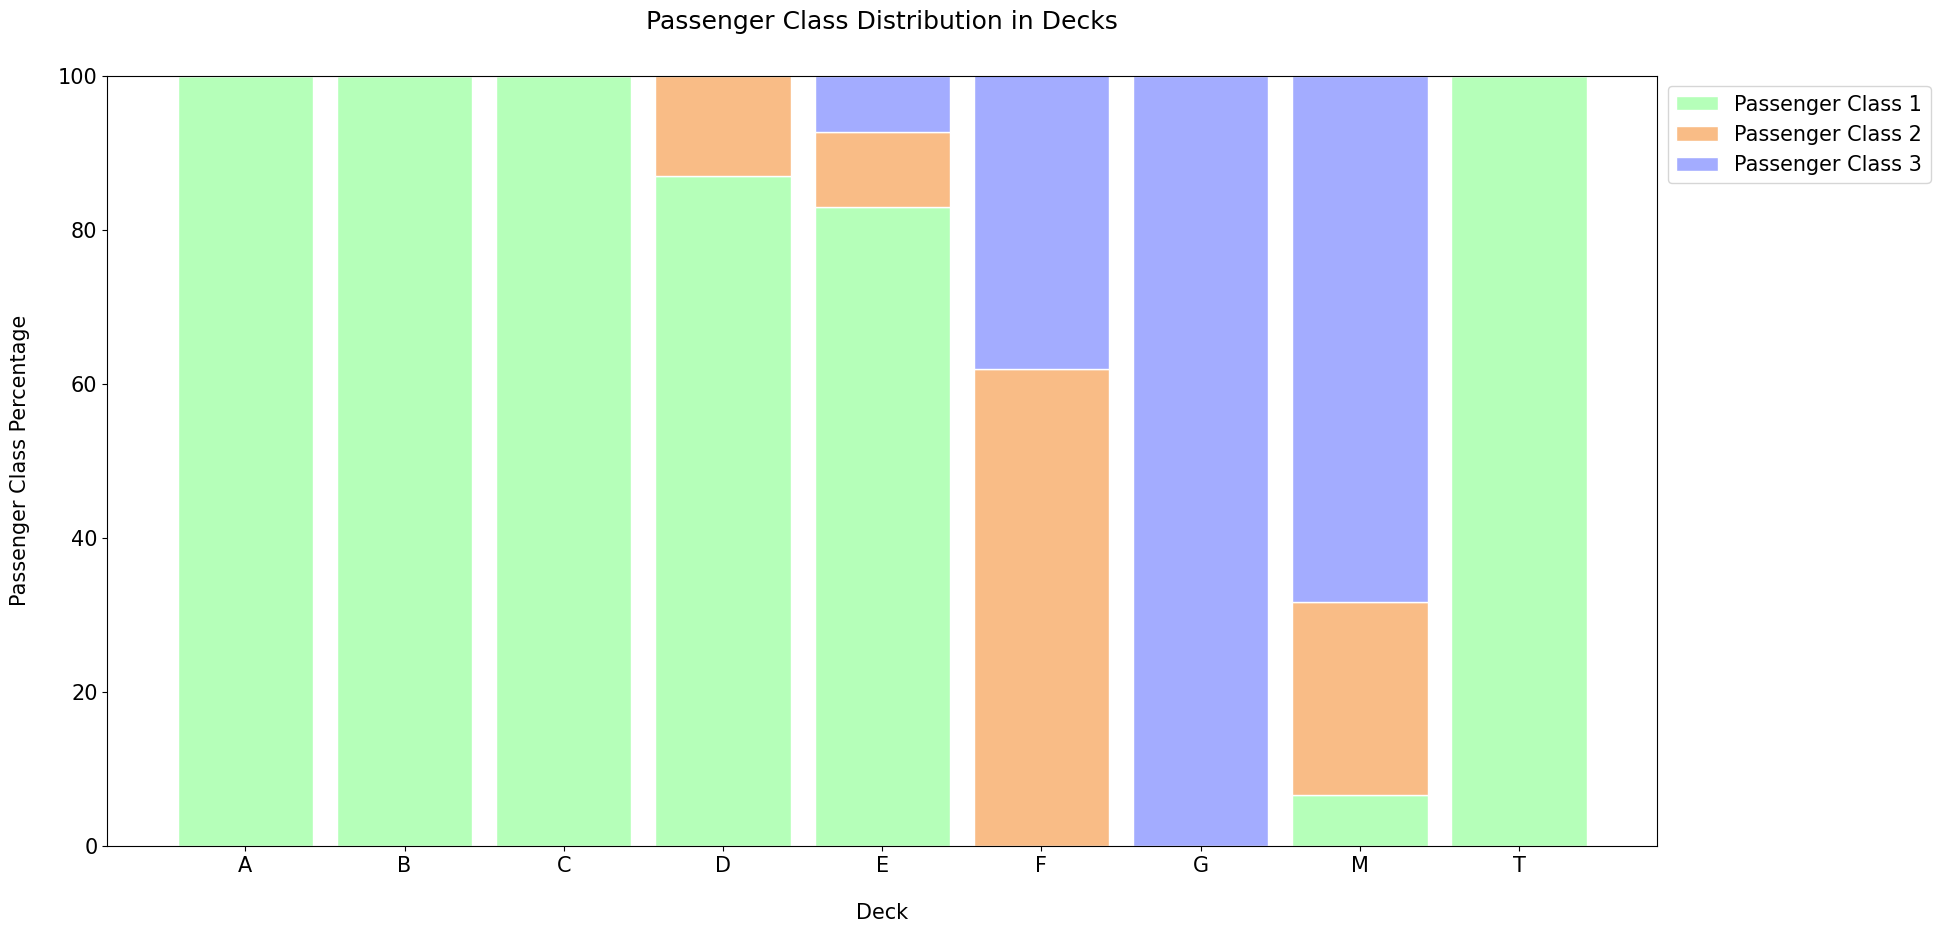

In [17]:
# Creating Deck column from the first letter of the Cabin column (M stands for Missing)
df_all['Deck'] = df_all['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

df_all_decks = df_all.groupby(['Deck', 'Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 
                                                                        'Fare', 'Embarked', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name': 'Count'}).transpose()

def get_pclass_dist(df):
    
    # Creating a dictionary for every passenger class count in every deck
    deck_counts = {'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}, 'F': {}, 'G': {}, 'M': {}, 'T': {}}
    decks = df.columns.levels[0]    
    
    for deck in decks:
        for pclass in range(1, 4):
            try:
                count = df[deck][pclass][0]
                deck_counts[deck][pclass] = count 
            except KeyError:
                deck_counts[deck][pclass] = 0
                
    df_decks = pd.DataFrame(deck_counts)    
    deck_percentages = {}

    # Creating a dictionary for every passenger class percentage in every deck
    for col in df_decks.columns:
        deck_percentages[col] = [(count / df_decks[col].sum()) * 100 for count in df_decks[col]]
        
    return deck_counts, deck_percentages

def display_pclass_dist(percentages):
    
    df_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85
    
    pclass1 = df_percentages[0]
    pclass2 = df_percentages[1]
    pclass3 = df_percentages[2]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, pclass1, color='#b5ffb9', edgecolor='white', width=bar_width, label='Passenger Class 1')
    plt.bar(bar_count, pclass2, bottom=pclass1, color='#f9bc86', edgecolor='white', width=bar_width, label='Passenger Class 2')
    plt.bar(bar_count, pclass3, bottom=pclass1 + pclass2, color='#a3acff', edgecolor='white', width=bar_width, label='Passenger Class 3')

    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Passenger Class Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Passenger Class Distribution in Decks', size=18, y=1.05)   
    
    plt.show()    

all_deck_count, all_deck_per = get_pclass_dist(df_all_decks)
display_pclass_dist(all_deck_per)

El 100 % de los pasajeros de las cubiertas A, B y C son de primera clase
La cubierta D tiene un 87 % de pasajeros de primera clase y un 13 % de pasajeros de segunda clase
La cubierta E tiene un 83 % de pasajeros de primera clase, un 10 % de pasajeros de segunda clase y un 7 % de pasajeros de tercera clase
La cubierta F tiene un 62 % de pasajeros de segunda clase y un 38 % de pasajeros de tercera clase
El 100 % de los pasajeros de la cubierta G son de tercera clase
Hay una persona en la cubierta del barco en la cabina T y es un pasajero de primera clase. El pasajero de la cabina T es el que más se parece a los pasajeros de la cubierta A, por lo que se agrupa con la cubierta A
Los pasajeros etiquetados como M son los valores que faltan en la función Cabina. No creo que sea posible encontrar la cubierta real de esos pasajeros, por lo que decidí usar M como cubierta

In [18]:
# Passenger in the T deck is changed to A
idx = df_all[df_all['Deck'] == 'T'].index
df_all.loc[idx, 'Deck'] = 'A'

C:\Users\AALP\AppData\Local\Temp\ipykernel_22444\3190326159.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  surv_counts[deck][survive] = df[deck][survive][0]


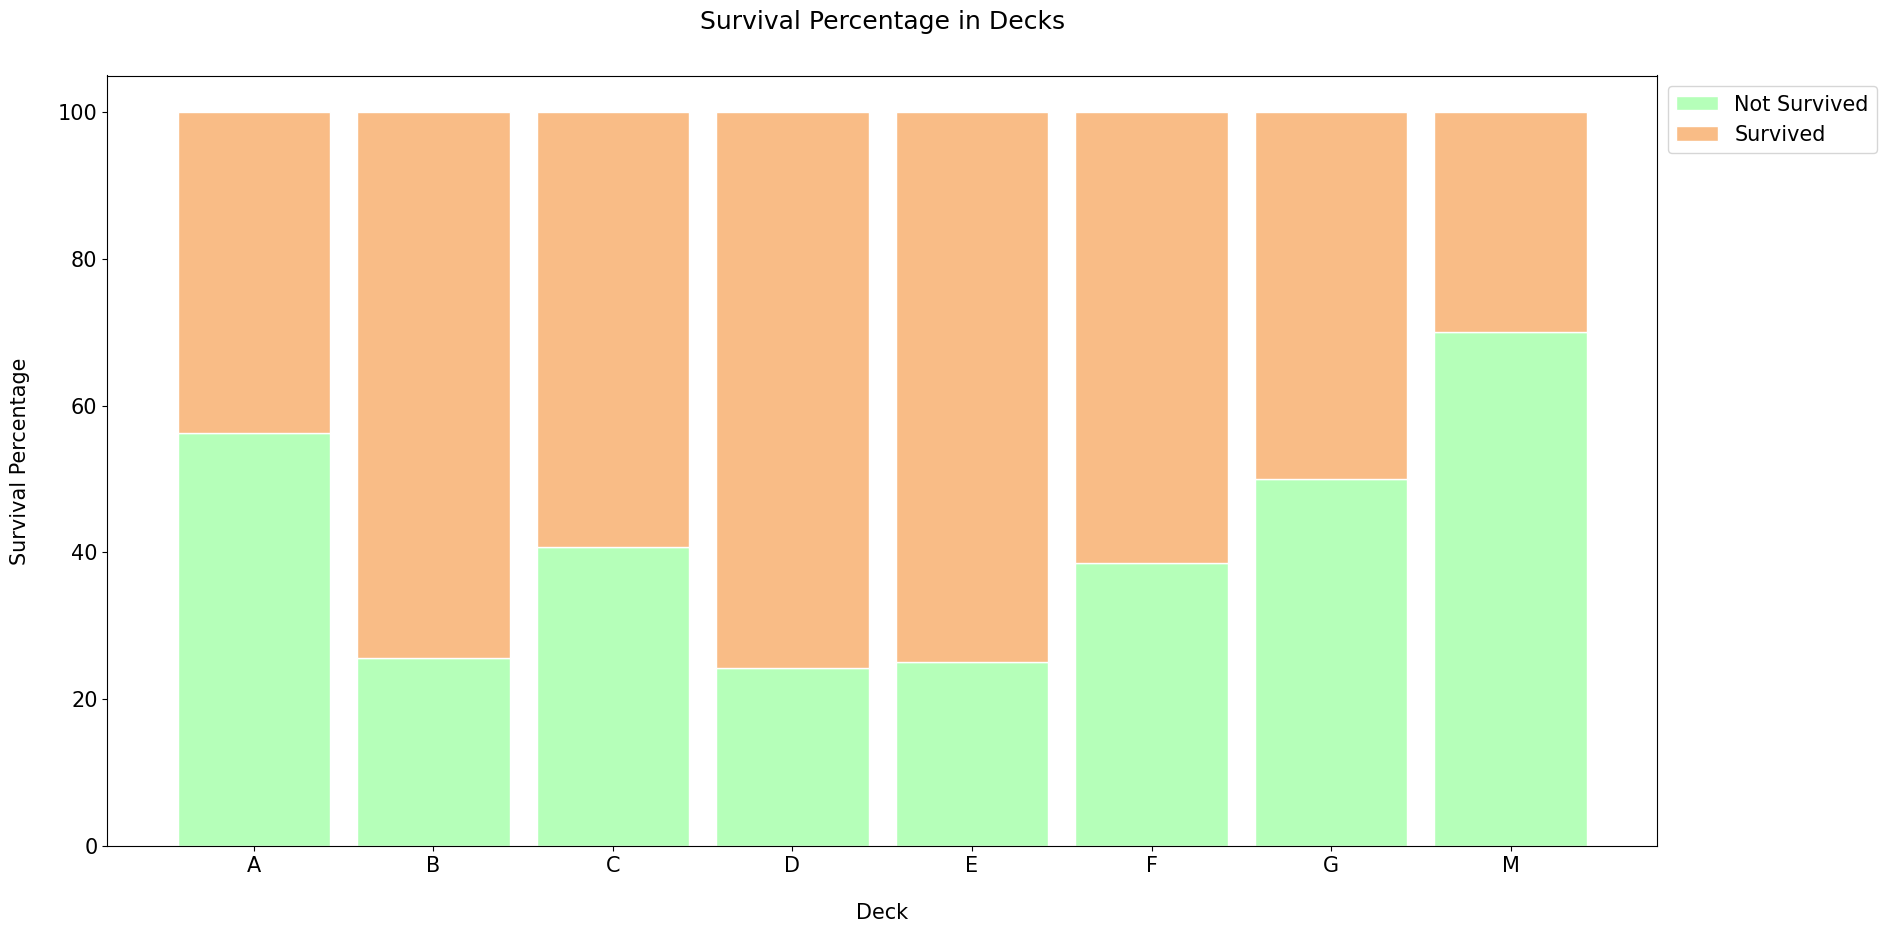

In [19]:
df_all_decks_survived = df_all.groupby(['Deck', 'Survived']).count().drop(columns=['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 
                                                                                   'Embarked', 'Pclass', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name':'Count'}).transpose()

def get_survived_dist(df):
    
    # Creating a dictionary for every survival count in every deck
    surv_counts = {'A':{}, 'B':{}, 'C':{}, 'D':{}, 'E':{}, 'F':{}, 'G':{}, 'M':{}}
    decks = df.columns.levels[0]    

    for deck in decks:
        for survive in range(0, 2):
            surv_counts[deck][survive] = df[deck][survive][0]
            
    df_surv = pd.DataFrame(surv_counts)
    surv_percentages = {}

    for col in df_surv.columns:
        surv_percentages[col] = [(count / df_surv[col].sum()) * 100 for count in df_surv[col]]
        
    return surv_counts, surv_percentages

def display_surv_dist(percentages):
    
    df_survived_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85    

    not_survived = df_survived_percentages[0]
    survived = df_survived_percentages[1]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, not_survived, color='#b5ffb9', edgecolor='white', width=bar_width, label="Not Survived")
    plt.bar(bar_count, survived, bottom=not_survived, color='#f9bc86', edgecolor='white', width=bar_width, label="Survived")
 
    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Survival Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Survival Percentage in Decks', size=18, y=1.05)
    
    plt.show()

all_surv_count, all_surv_per = get_survived_dist(df_all_decks_survived)
display_surv_dist(all_surv_per)

Como sospechaba, cada cubierta tiene diferentes tasas de supervivencia y esa información no se puede descartar. Las cubiertas B, C, D y E tienen las tasas de supervivencia más altas. Esas cubiertas están ocupadas principalmente por pasajeros de primera clase. M tiene la tasa de supervivencia más baja, que está ocupada principalmente por pasajeros de segunda y tercera clase. Para concluir, las cabinas utilizadas por pasajeros de primera clase tienen tasas de supervivencia más altas que las cabinas utilizadas por pasajeros de segunda y tercera clase. En mi opinión, M (valores de cabina faltantes) tiene la tasa de supervivencia más baja porque no pudieron recuperar los datos de cabina de las víctimas. Es por eso que creo que etiquetar ese grupo como M es una forma razonable de manejar los datos faltantes. Es un grupo único con características compartidas. La característica de la cubierta tiene una cardinalidad alta en este momento, por lo que algunos de los valores se agrupan entre sí en función de sus similitudes.

Las cubiertas A, B y C están etiquetadas como ABC porque todas ellas tienen solo pasajeros de primera clase.
Las cubiertas D y E están etiquetadas como DE porque ambas tienen una distribución de clase de pasajeros similar y la misma tasa de supervivencia.
Las cubiertas F y G están etiquetadas como FG por la misma razón mencionada anteriormente.
La cubierta M no necesita agruparse con otras cubiertas porque es muy diferente de las demás y tiene la tasa de supervivencia más baja.

In [20]:
df_all['Deck'] = df_all['Deck'].replace(['A', 'B', 'C'], 'ABC')
df_all['Deck'] = df_all['Deck'].replace(['D', 'E'], 'DE')
df_all['Deck'] = df_all['Deck'].replace(['F', 'G'], 'FG')

df_all['Deck'].value_counts()

Deck
M      1014
ABC     182
DE       87
FG       26
Name: count, dtype: int64

Después de completar los valores faltantes en las funciones Edad, Embarque, Tarifa y Cubierta, no queda ningún valor faltante en los conjuntos de entrenamiento y prueba. Se descarta la cabina porque se utiliza la función Cubierta en su lugar.

In [21]:
# Dropping the Cabin feature
df_all.drop(['Cabin'], inplace=True, axis=1)

df_train, df_test = divide_df(df_all)
dfs = [df_train, df_test]

for df in dfs:
    display_missing(df)

Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Survived column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0


Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0




### **1.3 Target Distribution**
* **38.38%** (342/891) of training set is **Class 1**
* **61.62%** (549/891) of training set is **Class 0**

342 of 891 passengers survived and it is the 38.38% of the training set.
549 of 891 passengers didnt survive and it is the 61.62% of the training set.


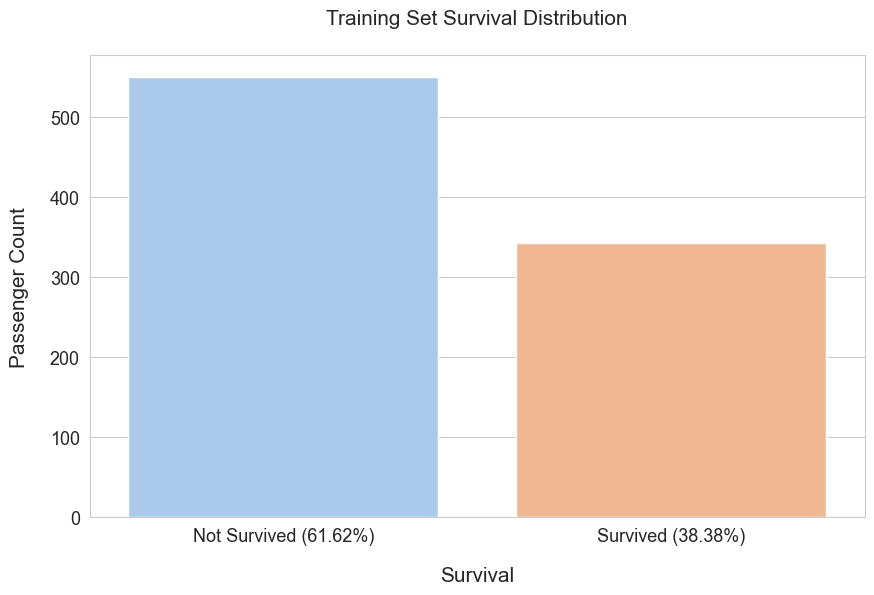

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular cantidad y porcentaje de sobrevivientes y no sobrevivientes
survived = df_train['Survived'].value_counts()[1]
not_survived = df_train['Survived'].value_counts()[0]
survived_per = survived / df_train.shape[0] * 100
not_survived_per = not_survived / df_train.shape[0] * 100

print('{} of {} passengers survived and it is the {:.2f}% of the training set.'.format(survived, df_train.shape[0], survived_per))
print('{} of {} passengers didnt survive and it is the {:.2f}% of the training set.'.format(not_survived, df_train.shape[0], not_survived_per))

# Ajustar tamaño de la figura para que sea más ancha
plt.figure(figsize=(10, 6))

# Aplicar un fondo similar al de la izquierda
sns.set_style("whitegrid")  

# Crear gráfico con colores diferenciados y sin la advertencia
sns.countplot(x="Survived", hue="Survived", data=df_train, palette="pastel", legend=False)

# Etiquetas y título
plt.xlabel('Survival', size=15, labelpad=15)
plt.ylabel('Passenger Count', size=15, labelpad=15)
plt.xticks((0, 1), ['Not Survived ({0:.2f}%)'.format(not_survived_per), 'Survived ({0:.2f}%)'.format(survived_per)])
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
plt.title('Training Set Survival Distribution', size=15, y=1.05)

plt.show()


### **1.4 Correlations**

Podemos analizar rápidamente nuestras correlaciones de características comparando las características entre sí. Solo podemos hacerlo en esta etapa ya que las características ya no tienen ningún valor vacío.

Las características están altamente correlacionadas entre sí y son dependientes entre sí. La correlación más alta entre características es **0,549500** en el conjunto de entrenamiento y **0,577147** en el conjunto de prueba (entre `Fare` y `Pclass`). Las otras características también están altamente correlacionadas. Hay **9** correlaciones en el conjunto de entrenamiento y **6** correlaciones en el conjunto de prueba que son superiores a **0,1**.

In [23]:
# Filtrar solo columnas numéricas antes de calcular la correlación
df_train_corr = df_train.select_dtypes(include=[np.number]).drop(['PassengerId'], axis=1, errors='ignore').corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_train_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_train_corr.drop(df_train_corr.iloc[1::2].index, inplace=True)
df_train_corr_nd = df_train_corr.drop(df_train_corr[df_train_corr['Correlation Coefficient'] == 1.0].index)

df_test_corr = df_test.select_dtypes(include=[np.number]).corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_test_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_test_corr.drop(df_test_corr.iloc[1::2].index, inplace=True)
df_test_corr_nd = df_test_corr.drop(df_test_corr[df_test_corr['Correlation Coefficient'] == 1.0].index)

In [24]:
# Training set high correlations
corr = df_train_corr_nd['Correlation Coefficient'] > 0.1
df_train_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
6,Fare,Pclass,0.549500
8,Age,Pclass,0.417667
10,Parch,SibSp,0.414838
12,Pclass,Survived,0.338481
14,Fare,Survived,0.257307
16,Age,SibSp,0.249747
18,Parch,Fare,0.216225
20,Parch,Age,0.176733
22,SibSp,Fare,0.159651
24,Age,Fare,0.124061


In [25]:
# Test set high correlations
corr = df_test_corr_nd['Correlation Coefficient'] > 0.1
df_test_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
6,Pclass,Fare,0.577489
8,Age,Pclass,0.526789
10,Age,Fare,0.345347
12,SibSp,Parch,0.306895
14,Parch,Fare,0.230410
16,Fare,SibSp,0.172032


In [26]:
# Filtrar solo columnas numéricas
df_train_num = df_train.select_dtypes(include=['number']).drop(['PassengerId'], axis=1, errors='ignore')
df_test_num = df_test.select_dtypes(include=['number']).drop(['PassengerId'], axis=1, errors='ignore')

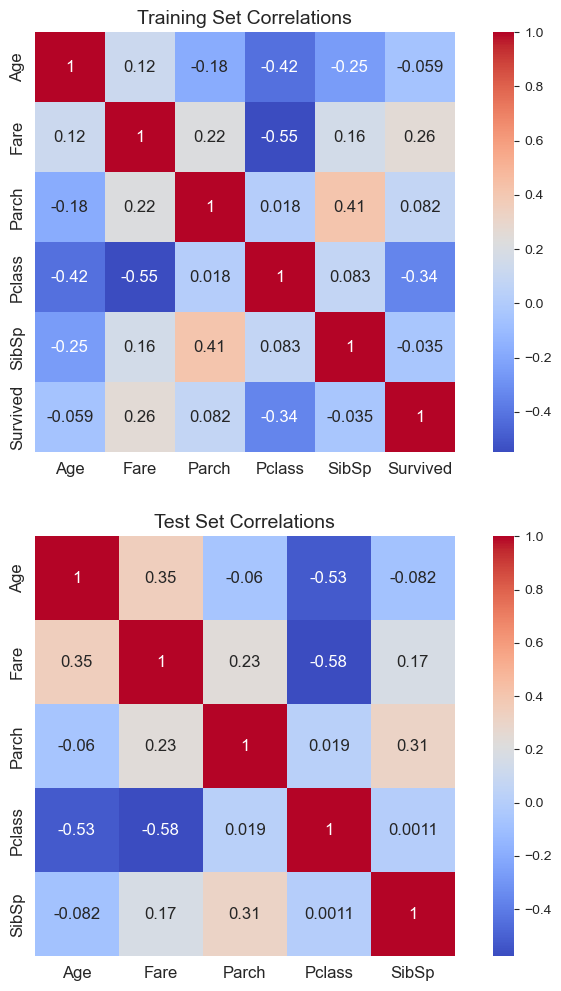

In [27]:
# Crear subgráficos
fig, axs = plt.subplots(nrows=2, figsize=(10, 12))  # Ajustar tamaño

# Heatmaps con anotaciones
sns.heatmap(df_train_num.corr(), ax=axs[0], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 12})


sns.heatmap(df_test_num.corr(), ax=axs[1], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 12})

# Ajustes de etiquetas
for i in range(2):    
    axs[i].tick_params(axis='x', labelsize=12)
    axs[i].tick_params(axis='y', labelsize=12)

# Títulos de los gráficos
axs[0].set_title('Training Set Correlations', size=14)
axs[1].set_title('Test Set Correlations', size=14)

plt.show()

Veamos más en detalle algunas de nuestras observaciones y suposiciones, analizardo rápidamente nuestras correlaciones con un poco más detalle.

Hay una correlación negativa entre Pclass y Survived, lo que sugiere que la clase del pasajero influyó en su probabilidad de sobrevivir.

In [28]:
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


se puede considerar que hay una correlación entre Sex y Survived

In [29]:
df_train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


SibSp y Parch Estas características tienen correlación cero para ciertos valores. 

In [30]:
df_train[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [31]:
df_train[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


### **1.5 Target Distribution in Features**  
Analizar mediante la visualización de datos

#### **1.5.1 Continuous Features**  
Ambas características continuas (Edad y Tarifa) tienen buenos puntos de división y picos para que un árbol de decisión aprenda. Un problema potencial para ambas características es que la distribución tiene más picos y protuberancias en el conjunto de entrenamiento, pero es más uniforme en el conjunto de prueba. Es posible que el modelo no pueda generalizarse al conjunto de prueba debido a este motivo.

La distribución de la característica Edad muestra claramente que los niños menores de 15 años tienen una tasa de supervivencia más alta que cualquiera de los otros grupos de edad.
En la distribución de la característica Tarifa, la tasa de supervivencia es más alta en las colas de la distribución. La distribución también tiene una asimetría positiva debido a los valores atípicos extremadamente grandes.


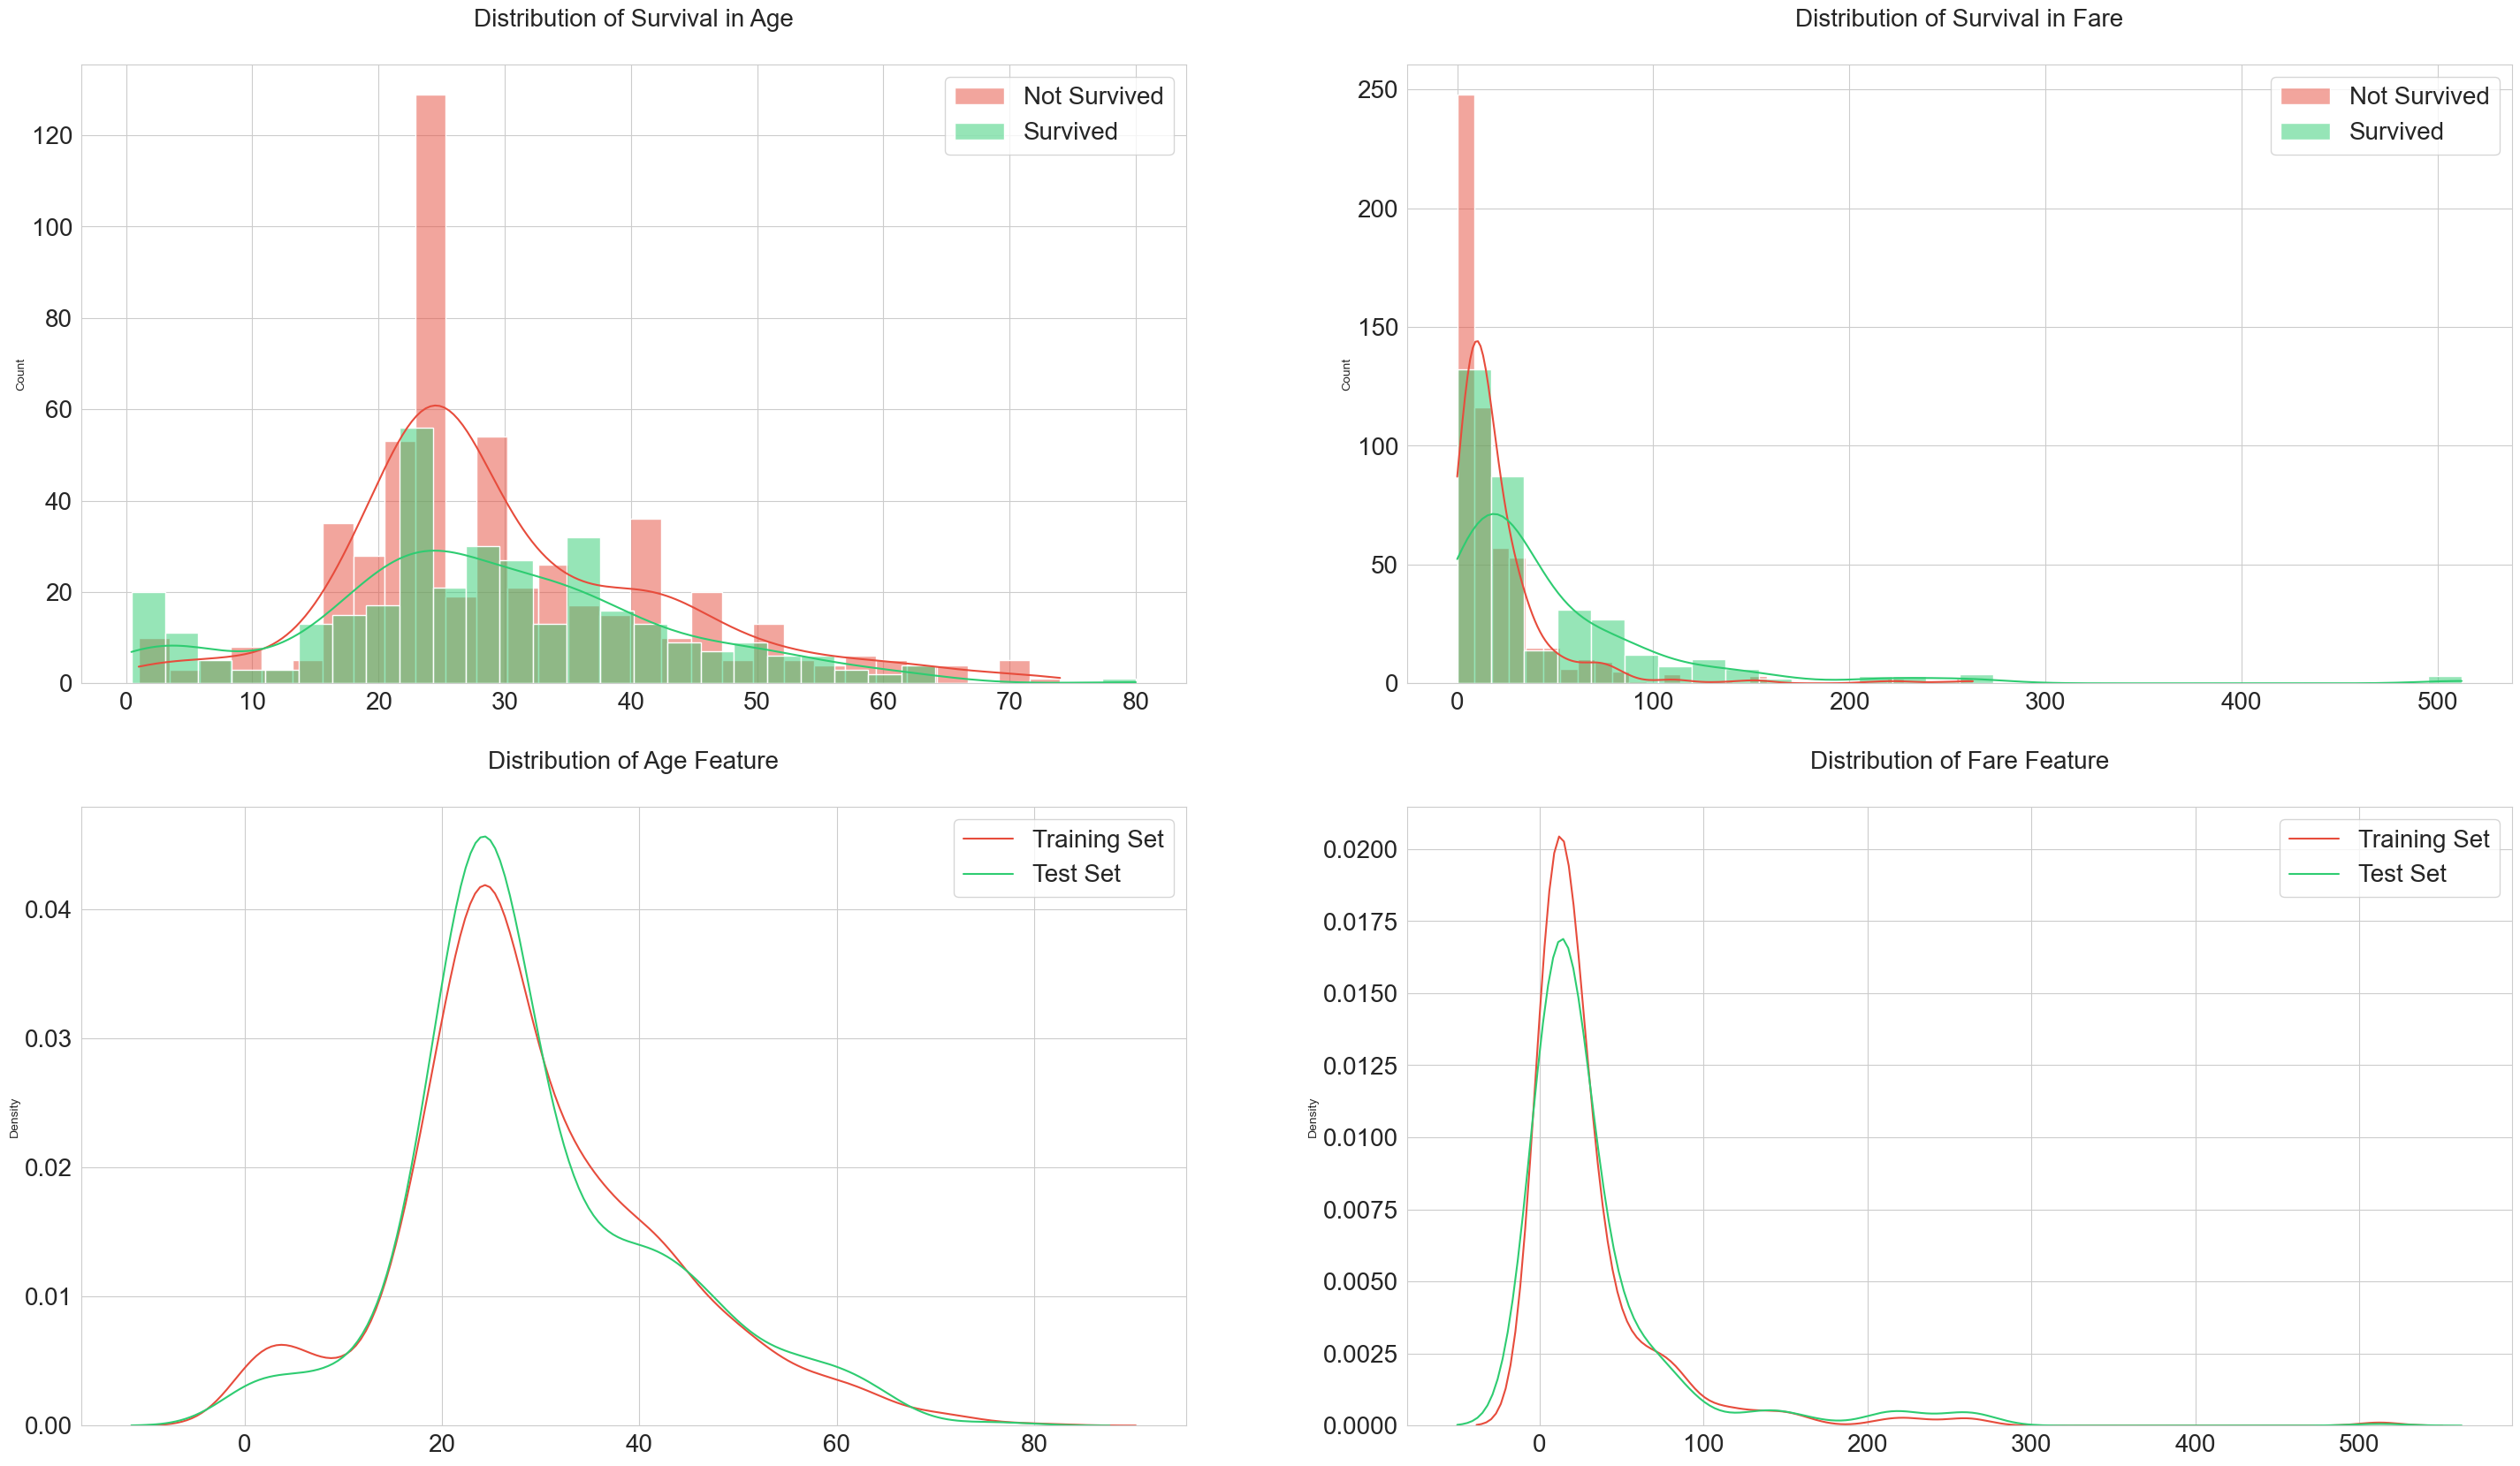

In [32]:


cont_features = ['Age', 'Fare']
surv = df_train['Survived'] == 1

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))
plt.subplots_adjust(right=1.5)

for i, feature in enumerate(cont_features):    
    # Distribución de sobrevivientes y no sobrevivientes (histogramas)
    sns.histplot(df_train[~surv][feature], label='Not Survived', bins=30, color='#e74c3c', kde=True, ax=axs[0][i])
    sns.histplot(df_train[surv][feature], label='Survived', bins=30, color='#2ecc71', kde=True, ax=axs[0][i])
    
    # Distribución de características en los datasets de entrenamiento y prueba (densidad)
    sns.kdeplot(df_train[feature], label='Training Set', color='#e74c3c', ax=axs[1][i])
    sns.kdeplot(df_test[feature], label='Test Set', color='#2ecc71', ax=axs[1][i])
    
    axs[0][i].set_xlabel('')
    axs[1][i].set_xlabel('')
    
    for j in range(2):        
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
    
    axs[0][i].legend(loc='upper right', prop={'size': 20})
    axs[1][i].legend(loc='upper right', prop={'size': 20})
    axs[0][i].set_title('Distribution of Survival in {}'.format(feature), size=20, y=1.05)

axs[1][0].set_title('Distribution of {} Feature'.format('Age'), size=20, y=1.05)
axs[1][1].set_title('Distribution of {} Feature'.format('Fare'), size=20, y=1.05)
        
plt.show()


Comencemos por comprender las correlaciones entre las características numéricas Edad y nuestro objetivo de solución (sobrevivencia).

Un gráfico de histograma es útil para analizar variables numéricas continuas como la edad, donde las bandas o los rangos ayudarán a identificar patrones útiles. El histograma puede indicar la distribución de muestras mediante contenedores definidos automáticamente o bandas de rangos iguales. Esto nos ayuda a responder preguntas relacionadas con bandas específicas (¿Los bebés tuvieron una mejor tasa de supervivencia?).

Tenga en cuenta que el eje x en las visualizaciones de histograma representa el recuento de muestras o pasajeros.

Observaciones.

Los bebés (edad <=4) tuvieron una alta tasa de supervivencia.
Los pasajeros de mayor edad (edad = 80) sobrevivieron.
Una gran cantidad de personas de entre 15 y 25 años no sobrevivieron.
La mayoría de los pasajeros están en el rango de edad de 15 a 35 años.

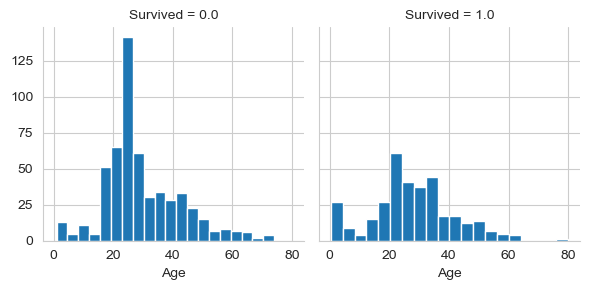

In [33]:
g = sns.FacetGrid(df_train, col='Survived')
g.map(plt.hist, 'Age', bins=20)

#### **1.5.2 Categorical Features**
Cada característica categórica tiene al menos una clase con una alta tasa de mortalidad. Esas clases son muy útiles para predecir si el pasajero es un sobreviviente o una víctima. Las mejores características categóricas son `Pclass` y `Sex` porque tienen las distribuciones más homogéneas.

* Los pasajeros embarcados desde **Southampton** tienen una tasa de supervivencia más baja a diferencia de otros puertos. Más de la mitad de los pasajeros embarcados desde **Cherbourg** habían sobrevivido. Esta observación podría estar relacionada con la característica `Pclass`
* Las características `Parch` y `SibSp` muestran que los pasajeros con solo un miembro de la familia tienen una tasa de supervivencia más alta

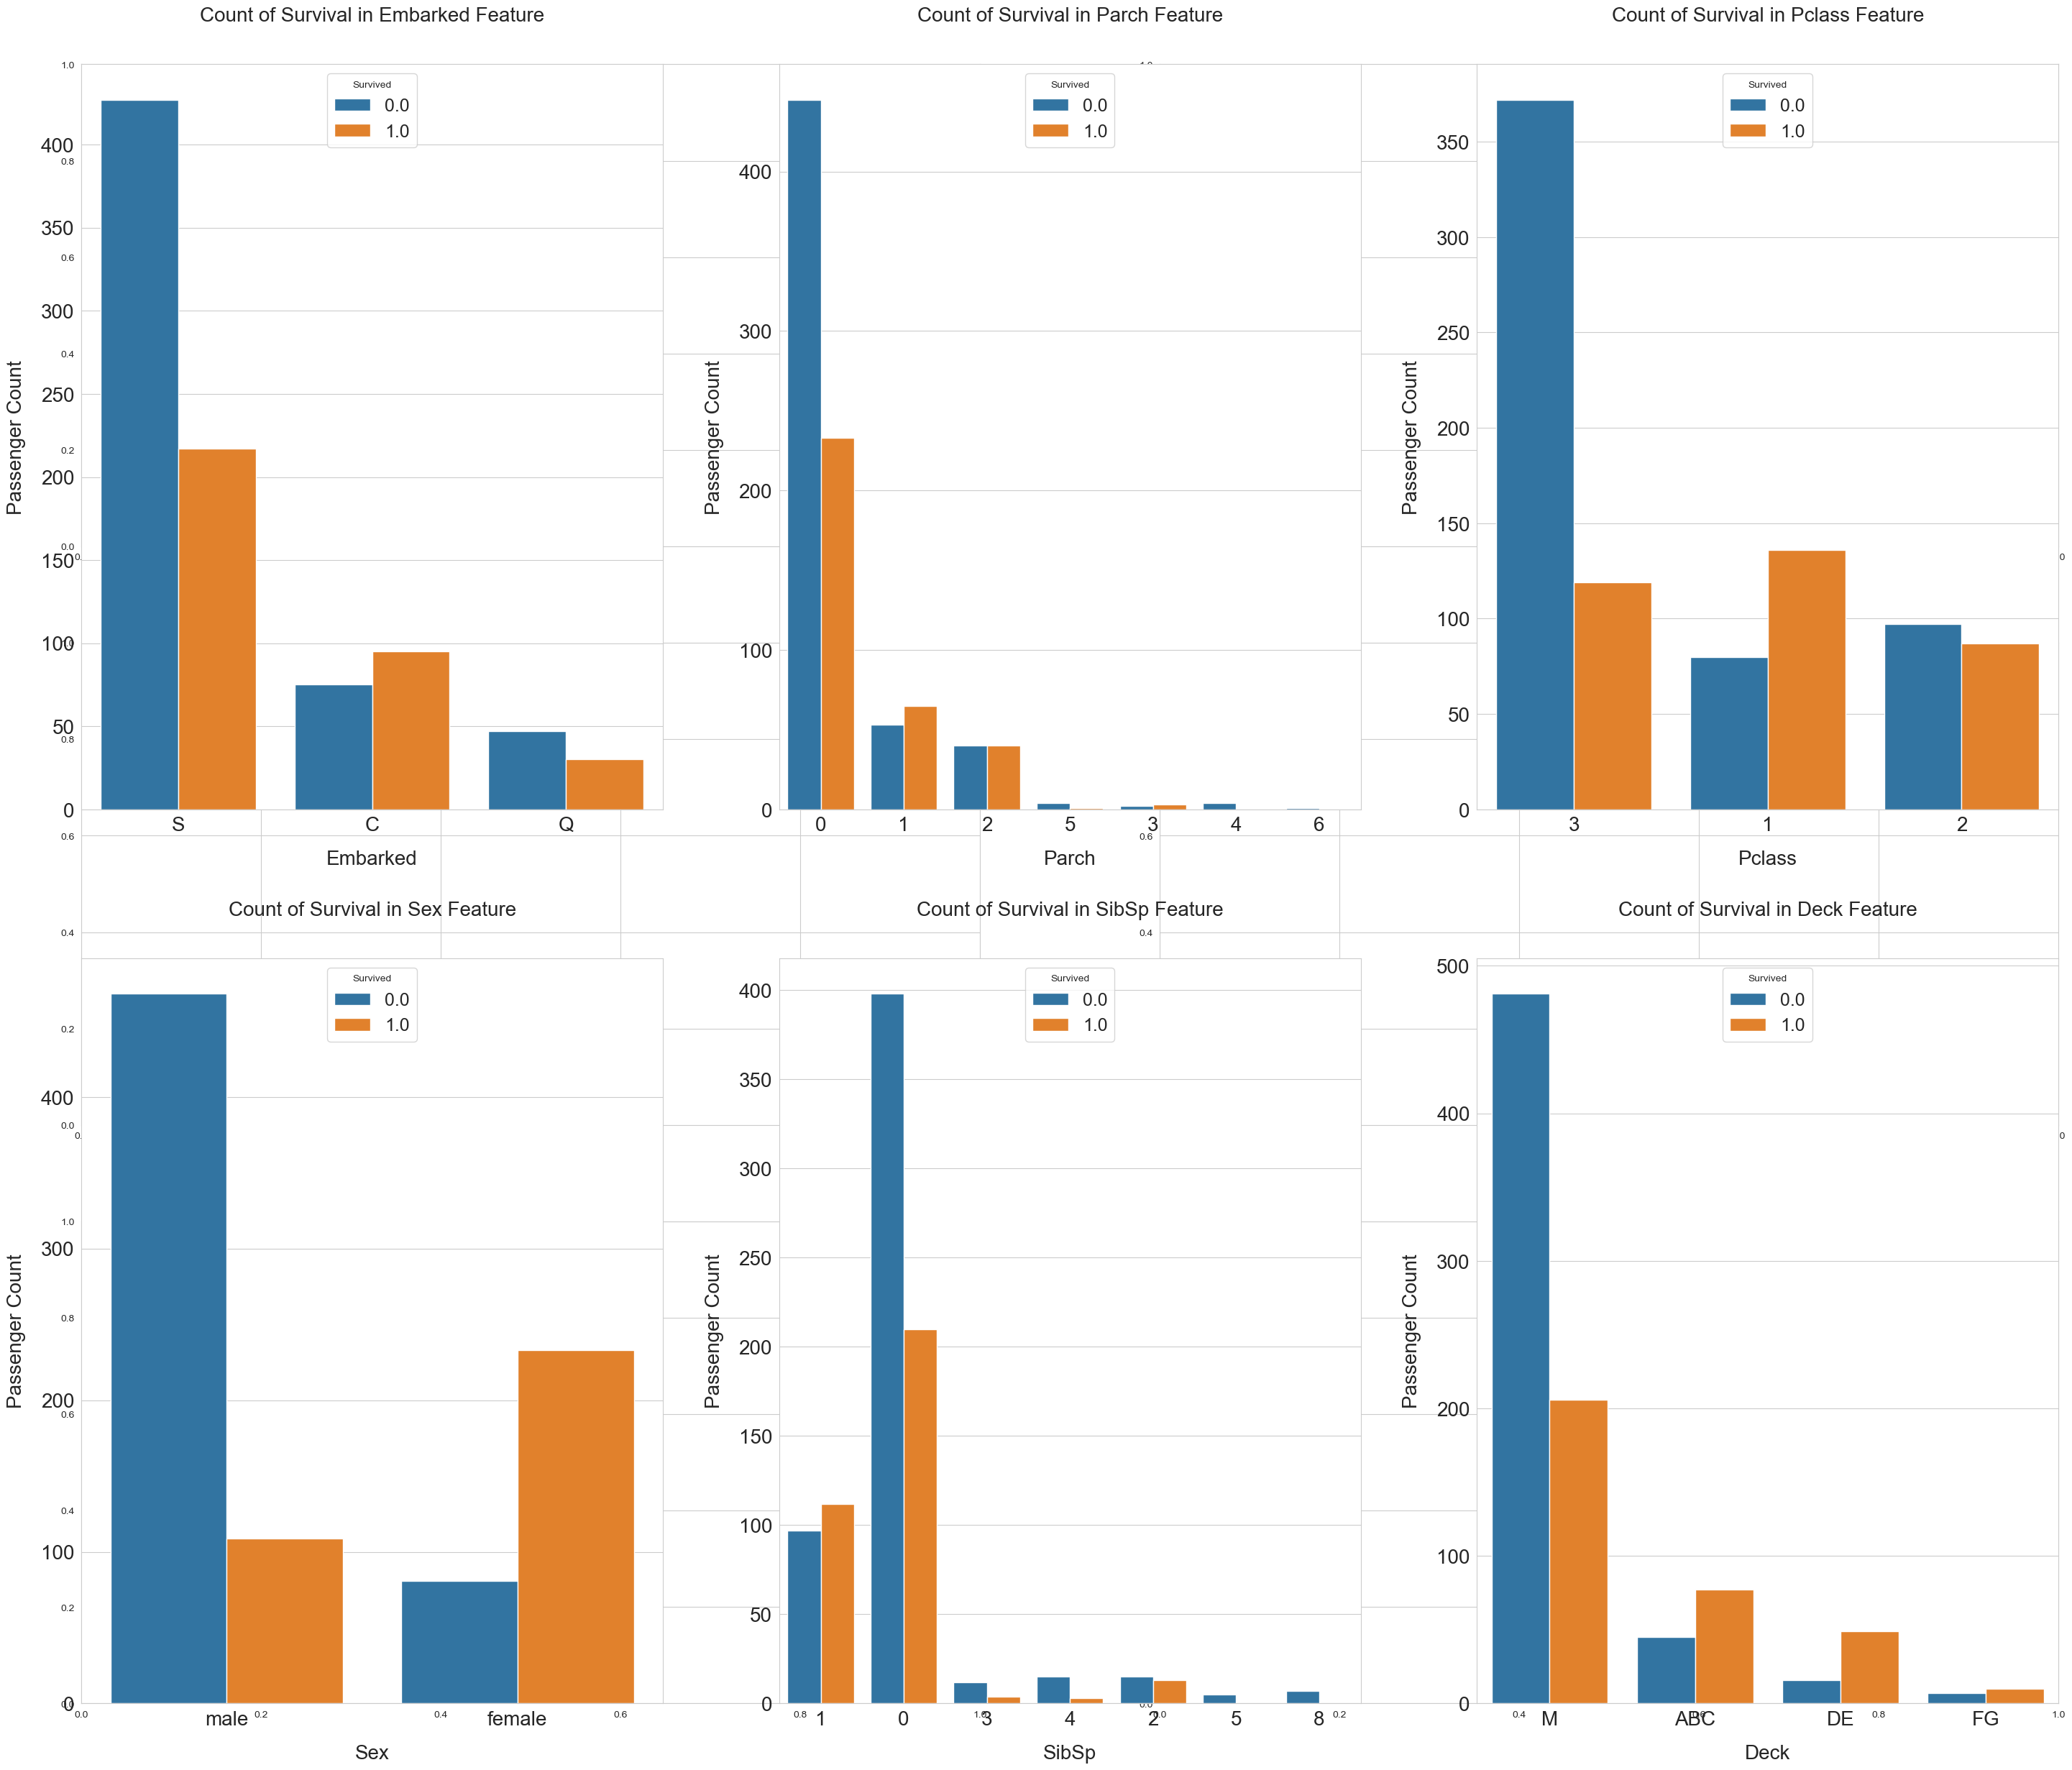

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Definir las características categóricas
cat_features = ['Embarked', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Deck']

# 1️⃣ Verificar si alguna columna no está en df_train y eliminarla
cat_features = [col for col in cat_features if col in df_train.columns]

# 2️⃣ Convertir 'Survived' en string para evitar problemas con Seaborn (usando .loc)
df_train.loc[:, 'Survived'] = df_train['Survived'].astype(str)

# 3️⃣ Convertir las características categóricas a string usando .loc
df_train.loc[:, cat_features] = df_train[cat_features].astype(str)

# 4️⃣ Manejo de valores NaN (reemplazarlos con "Unknown") usando .loc
df_train.loc[:, cat_features] = df_train[cat_features].fillna("Unknown")

# 5️⃣ Crear la figura con 2 columnas y 3 filas
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(20, 20))
plt.subplots_adjust(right=1.5, top=1.25)

# 6️⃣ Generar gráficos para cada variable categórica
for i, feature in enumerate(cat_features, 1):    
    plt.subplot(2, 3, i)
    sns.countplot(x=feature, hue='Survived', data=df_train)
    
    plt.xlabel(feature, size=20, labelpad=15)
    plt.ylabel('Passenger Count', size=20, labelpad=15)    
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    
    plt.legend(title="Survived", loc='upper center', prop={'size': 18})
    plt.title(f'Count of Survival in {feature} Feature', size=20, y=1.05)

plt.show()


Pclass=3 tenía la mayoría de los pasajeros, sin embargo la mayoría no sobrevivió. Confirma nuestra suposición de clasificación n.° 2.
Los pasajeros bebés en Pclass=2 y Pclass=3 sobrevivieron en su mayoría. Califica aún más nuestra suposición de clasificación n.° 2.
La mayoría de los pasajeros en Pclass=1 sobrevivieron. Confirma nuestra suposición de clasificación n.° 3.
Pclass varía en términos de la distribución de edad de los pasajeros.

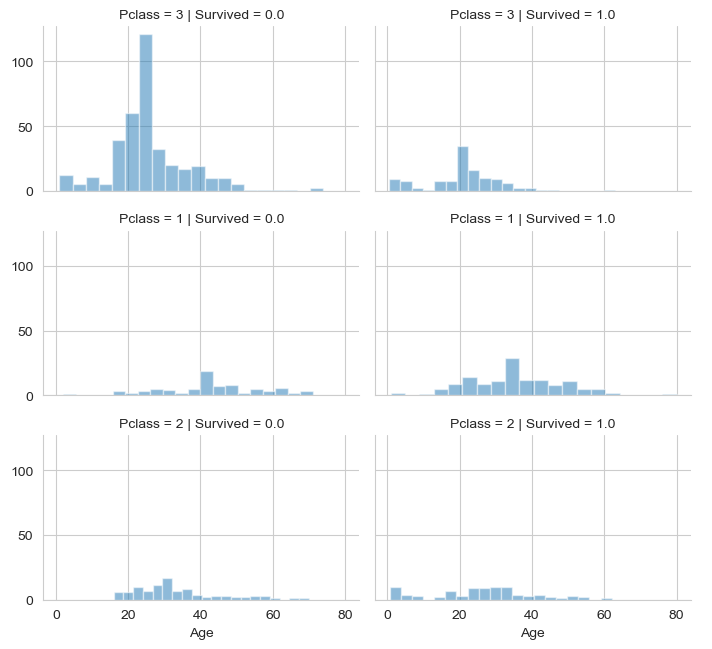

In [35]:
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Survived')
grid = sns.FacetGrid(df_train, col='Survived', row='Pclass', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

Las pasajeras tuvieron una tasa de supervivencia mucho mejor que los pasajeros masculinos. Confirma la clasificación (#1).
Excepción en Embarked=C donde los pasajeros masculinos tuvieron una tasa de supervivencia más alta. Esto podría ser una correlación entre Pclass y Embarked y a su vez Pclass y Survived, no necesariamente una correlación directa entre Embarked y Survived.
Los pasajeros masculinos tuvieron una mejor tasa de supervivencia en Pclass=3 en comparación con Pclass=2 para los puertos C y Q. Completando (#2).
Los puertos de embarque tienen tasas de supervivencia variables para Pclass=3 y entre pasajeros masculinos. Correlación (#1).

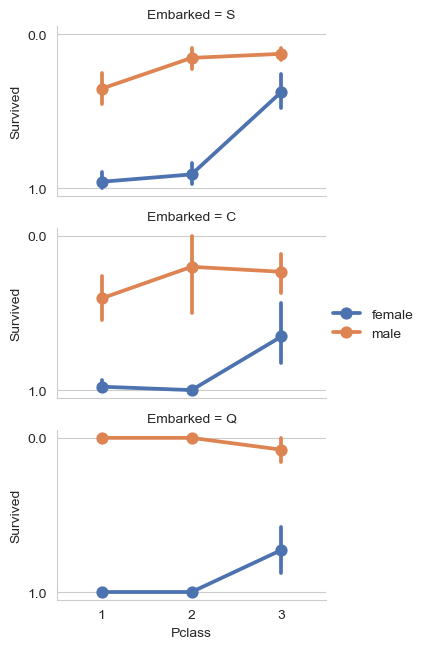

In [36]:

# Definir el orden de las variables categóricas
pclass_order = sorted(df_train['Pclass'].unique())  # Ordenar Pclass
sex_order = sorted(df_train['Sex'].unique())  # Ordenar Sex

# Crear el FacetGrid con filas por 'Embarked'
grid = sns.FacetGrid(df_train, row='Embarked', height=2.2, aspect=1.6)

# Agregar pointplot con orden definido
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', 
         palette='deep', order=pclass_order, hue_order=sex_order)

# Agregar la leyenda
grid.add_legend()

plt.show()


Los pasajeros que pagaron tarifas más altas tuvieron una mejor supervivencia. Confirma nuestra suposición para crear rangos de tarifas (#4).
El puerto de embarque se correlaciona con las tasas de supervivencia. Confirma la correlación (#1) y la finalización (#2).

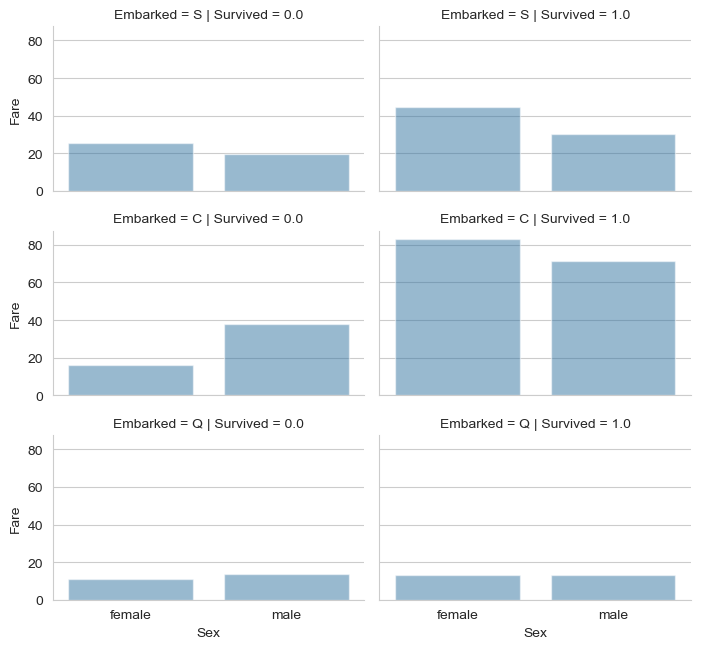

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ordenar los valores únicos de 'Sex' para asegurar un orden correcto
sex_order = sorted(df_train['Sex'].unique())

# Crear FacetGrid con filas por 'Embarked' y columnas por 'Survived'
grid = sns.FacetGrid(df_train, row='Embarked', col='Survived', height=2.2, aspect=1.6)

# Agregar `barplot` con parámetros corregidos
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, order=sex_order, errorbar=None)

# Agregar leyenda
grid.add_legend()

# Mostrar gráfico
plt.show()


### **1.6 Conclusion**
La mayoría de las características están correlacionadas entre sí. Esta relación se puede utilizar para crear nuevas características con la transformación de características y la interacción de características. La codificación de destino también podría ser muy útil debido a las altas correlaciones con la característica `Survived`.

Los puntos de división y los picos son visibles en las características continuas. Se pueden capturar fácilmente con un modelo de árbol de decisión, pero los modelos lineales pueden no ser capaces de detectarlos.

Las características categóricas tienen distribuciones muy distintas con diferentes tasas de supervivencia. Esas características se pueden codificar one-hot. Algunas de esas características se pueden combinar entre sí para crear nuevas características.

Se creó una nueva característica llamada `Deck` y se eliminó la característica `Cabin` en la parte **Exploratory Data Analysis**.

In [38]:
df_all = concat_df(df_train, df_test)
df_all.head()



,Age,Deck,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,M,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,ABC,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,M,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,ABC,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,M,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [39]:
df_backup = df_all.copy()  # Guardar copia antes de modificar

## **2. Feature Engineering**

### **2.1 Binning Continuous Features**

#### **2.1.1 Fare**
La característica `Tarifa` está sesgada positivamente y la tasa de supervivencia es extremadamente alta en el extremo derecho. Se utilizan **13** compartimentos basados ​​en cuartiles para la característica `Tarifa`. Aunque los compartimentos son demasiados, proporcionan una cantidad decente de ganancia de información. Los grupos en el lado izquierdo del gráfico tienen la tasa de supervivencia más baja y los grupos en el lado derecho del gráfico tienen la tasa de supervivencia más alta. Esta alta tasa de supervivencia no era visible en el gráfico de distribución. También hay un grupo inusual **(15.742, 23.25]** en el medio con una alta tasa de supervivencia que se captura en este proceso.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.histplot(df_all['Fare'], bins=30, kde=True)
plt.title("Distribución de Fare")
plt.show()


al cambiar la cantidad de bins vemos una mejor separación de la tasa de supervivencia, entonces ese número de bins es el mejor.

In [53]:
# Asegurar que 'Survived' es numérico
df_all['Survived'] = pd.to_numeric(df_all['Survived'], errors='coerce')

for bins in [4, 6, 8, 10, 13, 15]:
    df_all['FareBand'] = pd.qcut(df_all['Fare'], bins, duplicates='drop')
    print(f"\nBins: {bins}")
    print(df_all[['FareBand', 'Survived']].groupby(['FareBand'], observed=False).mean())



Bins: 4
                   Survived
FareBand                   
(-0.001, 7.896]    0.197309
(7.896, 14.454]    0.303571
(14.454, 31.275]   0.441048
(31.275, 512.329]  0.600000

Bins: 6
                 Survived
FareBand                 
(-0.001, 7.775]  0.205128
(7.775, 8.662]   0.190789
(8.662, 14.454]  0.366906
(14.454, 26.0]   0.436242
(26.0, 53.1]     0.435065
(53.1, 512.329]  0.695035

Bins: 8
                  Survived
FareBand                  
(-0.001, 7.75]    0.207143
(7.75, 7.896]     0.180723
(7.896, 9.844]    0.205357
(9.844, 14.454]   0.401786
(14.454, 24.15]   0.436364
(24.15, 31.275]   0.445378
(31.275, 69.55]   0.481818
(69.55, 512.329]  0.723810

Bins: 10
                  Survived
FareBand                  
(-0.001, 7.57]    0.141304
(7.57, 7.854]     0.298851
(7.854, 8.05]     0.179245
(8.05, 10.5]      0.230769
(10.5, 14.454]    0.428571
(14.454, 21.558]  0.425287
(21.558, 26.82]   0.511364
(26.82, 41.579]   0.381443
(41.579, 78.02]   0.529412
(78.02, 512.329]  0.

la ganancia de información entre FareBand y Survived utilizando la información mutua (mutual information, MI), que mide la reducción de la incertidumbre en Survived al conocer FareBand.  
la curva se estabiliza en un punto (por ejemplo, en 10-15 bins), usar más bins no aporta más información significativa y solo aumenta la complejidad.

Crecimiento inicial (2-10 bins):

A medida que aumentamos el número de bins, la información mutua aumenta de forma consistente.
Esto sugiere que dividir Fare en más segmentos mejora la diferenciación entre sobrevivientes y no sobrevivientes.
Zona de estabilidad (10-14 bins):

Entre 10 y 14 bins, la información mutua oscila pero no aumenta significativamente.
Este punto puede ser un número óptimo de bins, ya que más división no aporta mucha más información.
Aumento final (15-20 bins):

Hay un ligero aumento, lo que indica que aún puede haber algo de información útil en más bins.
Sin embargo, si seguimos aumentando los bins, podemos caer en overfitting, donde los datos se dividen demasiado y se introduce ruido.

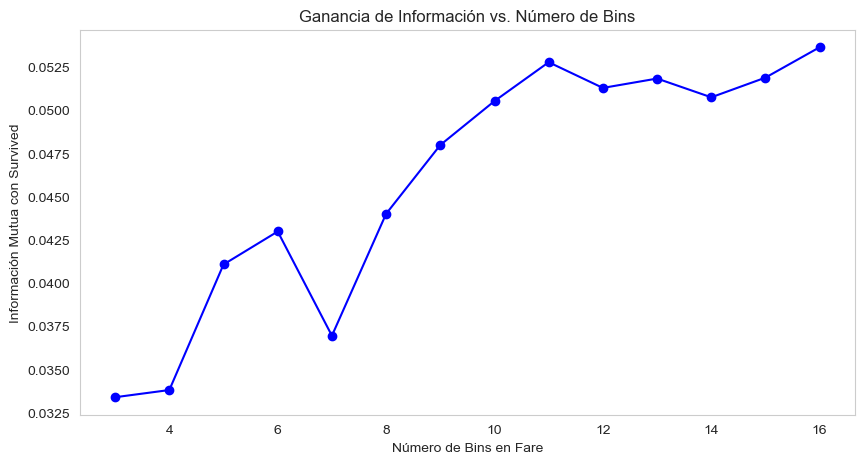

In [54]:
import numpy as np
import pandas as pd
from sklearn.metrics import mutual_info_score
import matplotlib.pyplot as plt



# Rellenar NaN en Fare con la mediana (puedes cambiarlo por el mínimo positivo si prefieres)
##df_all['Fare'].fillna(df_all['Fare'].median(), inplace=True)

# Definir diferentes números de bins para Fare
bin_counts = list(range(3, 17))  # Evaluamos desde 2 hasta 20 bins
mi_scores = []  # Lista para almacenar la información mutua

for bins in bin_counts:
    df_all['FareBand'] = pd.qcut(df_all['Fare'], bins, duplicates='drop')  # Evitar duplicados
    mi = mutual_info_score(df_all['FareBand'].astype(str), df_all['Survived'].astype(str))  # Convertir a str
    mi_scores.append(mi)

# Graficar la información mutua vs. número de bins
plt.figure(figsize=(10, 5))
plt.plot(bin_counts, mi_scores, marker='o', linestyle='-', color='b')
plt.xlabel("Número de Bins en Fare")
plt.ylabel("Información Mutua con Survived")
plt.title("Ganancia de Información vs. Número de Bins")
plt.grid()
plt.show()


In [46]:
df_all = df_backup.copy()


In [55]:
df_all['Fare'] = pd.qcut(df_all['Fare'], 13)

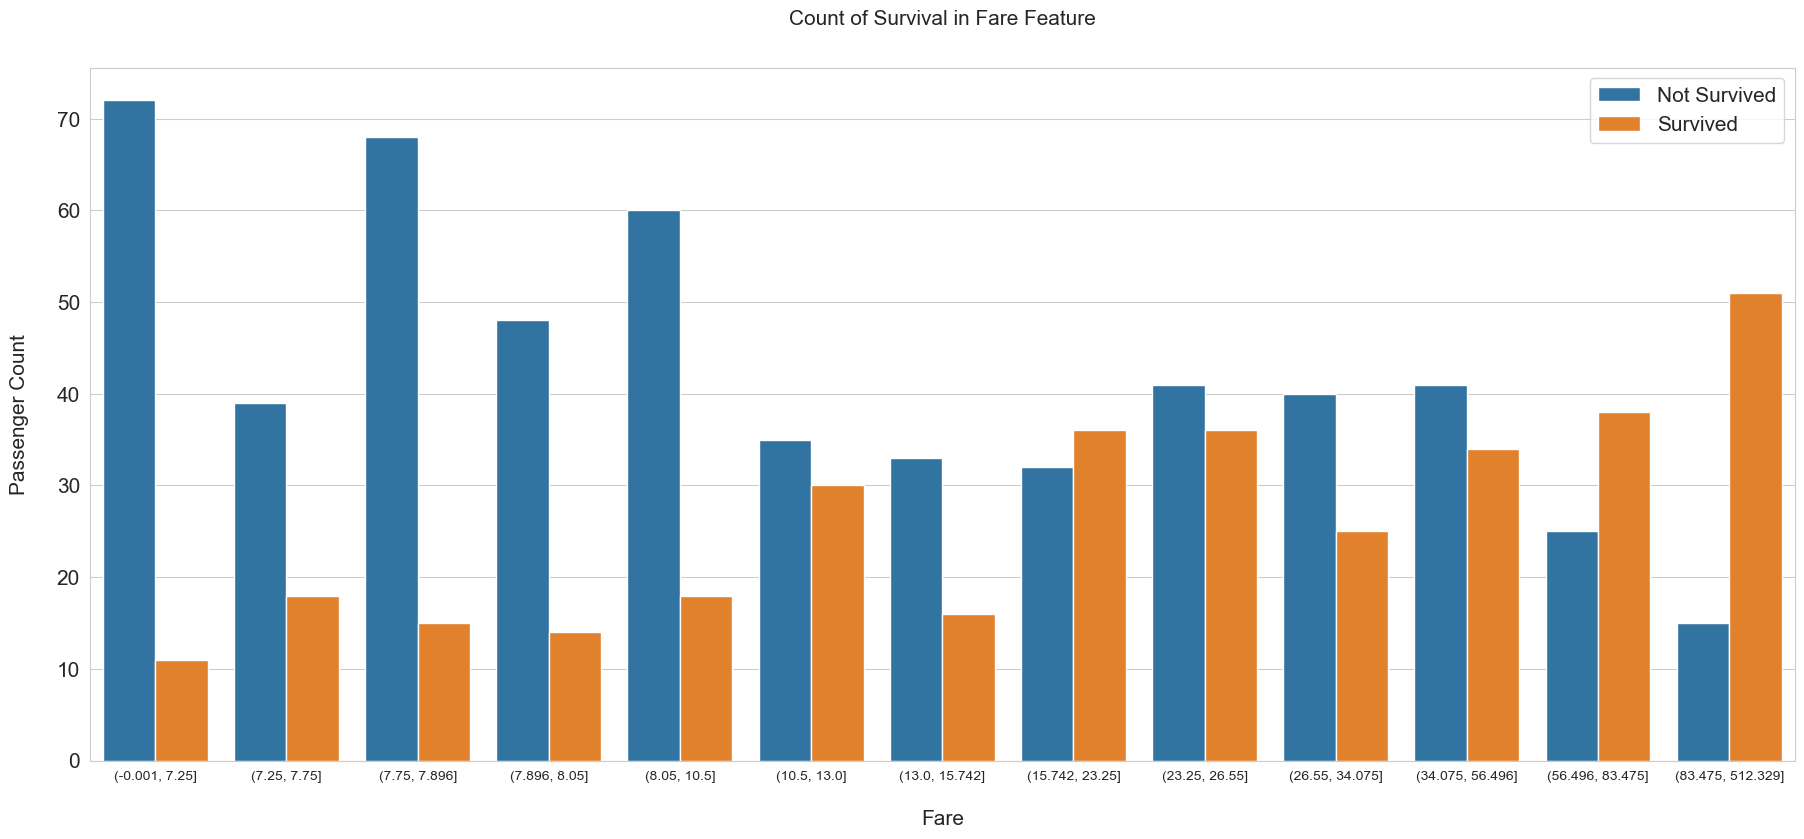

In [56]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Fare', hue='Survived', data=df_all)

plt.xlabel('Fare', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Fare'), size=15, y=1.05)

plt.show()

#### **2.1.2 Age**
`Age` feature has a normal distribution with some spikes and bumps and **10** quantile based bins are used for `Age`. The first bin has the highest survival rate and 4th bin has the lowest survival rate. Those were the biggest spikes in the distribution. There is also an unusual group **(34.0, 40.0]** with high survival rate that is captured in this process.

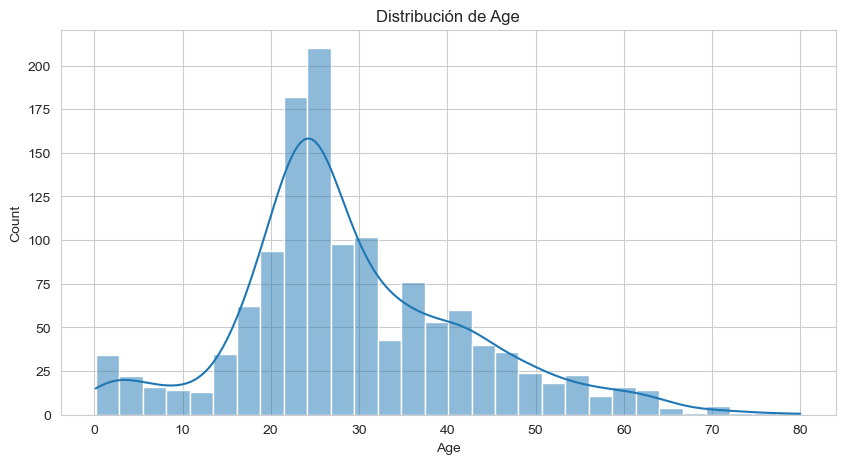

In [57]:
plt.figure(figsize=(10,5))
sns.histplot(df_all['Age'], bins=30, kde=True)
plt.title("Distribución de Age")
plt.show()

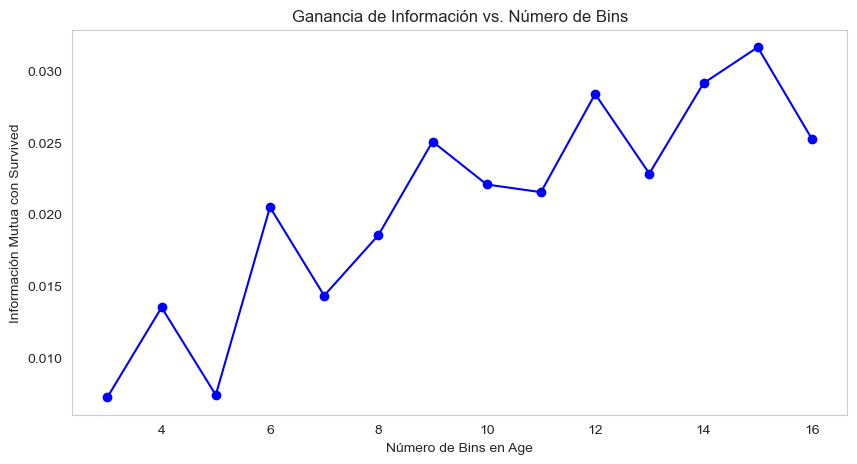

In [58]:
for bins in [4, 6, 8, 10, 13, 15]:
    df_all['AgeBand'] = pd.qcut(df_all['Age'], bins, duplicates='drop')
    
# Definir diferentes números de bins para Age
bin_counts = list(range(3, 17))  # Evaluamos desde 2 hasta 20 bins
mi_scores = []  # Lista para almacenar la información mutua

for bins in bin_counts:
    df_all['AgeBand'] = pd.qcut(df_all['Age'], bins, duplicates='drop')  # Evitar duplicados
    mi = mutual_info_score(df_all['AgeBand'].astype(str), df_all['Survived'].astype(str))  # Convertir a str
    mi_scores.append(mi)

# Graficar la información mutua vs. número de bins
plt.figure(figsize=(10, 5))
plt.plot(bin_counts, mi_scores, marker='o', linestyle='-', color='b')
plt.xlabel("Número de Bins en Age")
plt.ylabel("Información Mutua con Survived")
plt.title("Ganancia de Información vs. Número de Bins")
plt.grid()
plt.show()

In [59]:
df_all['Age'] = pd.qcut(df_all['Age'], 10)

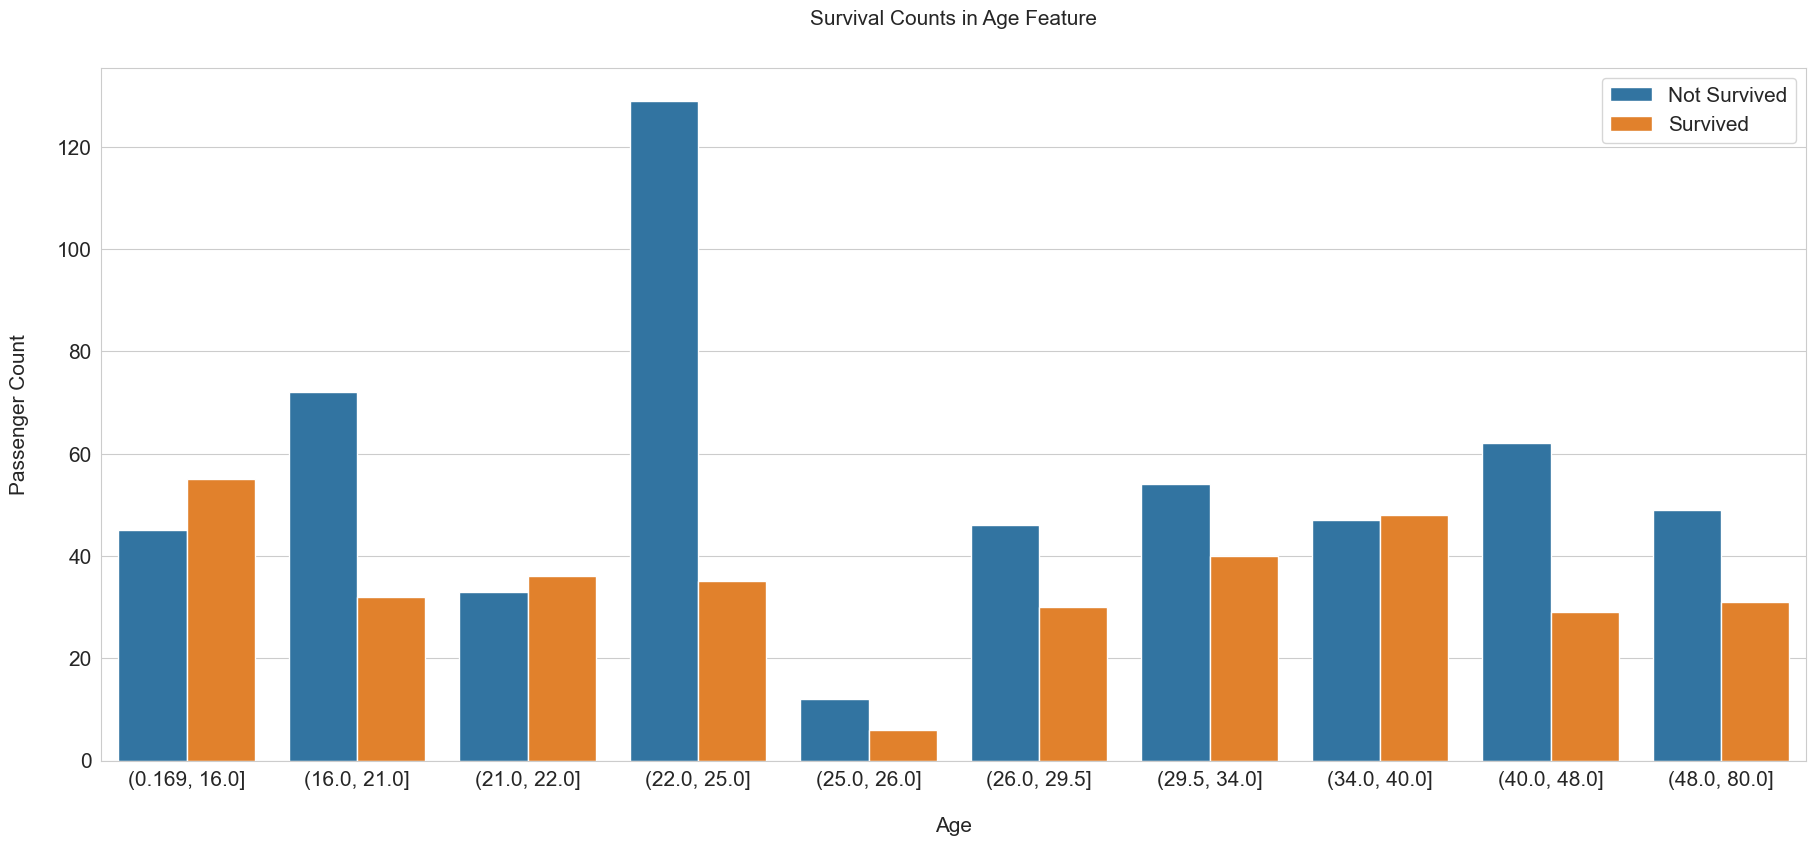

In [60]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Age', hue='Survived', data=df_all)

plt.xlabel('Age', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Survival Counts in {} Feature'.format('Age'), size=15, y=1.05)

plt.show()

In [68]:
df_all = df_backup.copy()


### **2.2 Frequency Encoding**
`Family_Size` is created by adding `SibSp`, `Parch` and **1**. `SibSp` is the count of siblings and spouse, and `Parch` is the count of parents and children. Those columns are added in order to find the total size of families. Adding **1** at the end, is the current passenger. Graphs have clearly shown that family size is a predictor of survival because different values have different survival rates.
* Family Size with **1** are labeled as **Alone**
* Family Size with **2**, **3** and **4** are labeled as **Small**
* Family Size with **5** and **6** are labeled as **Medium**
* Family Size with **7**, **8** and **11** are labeled as **Large**

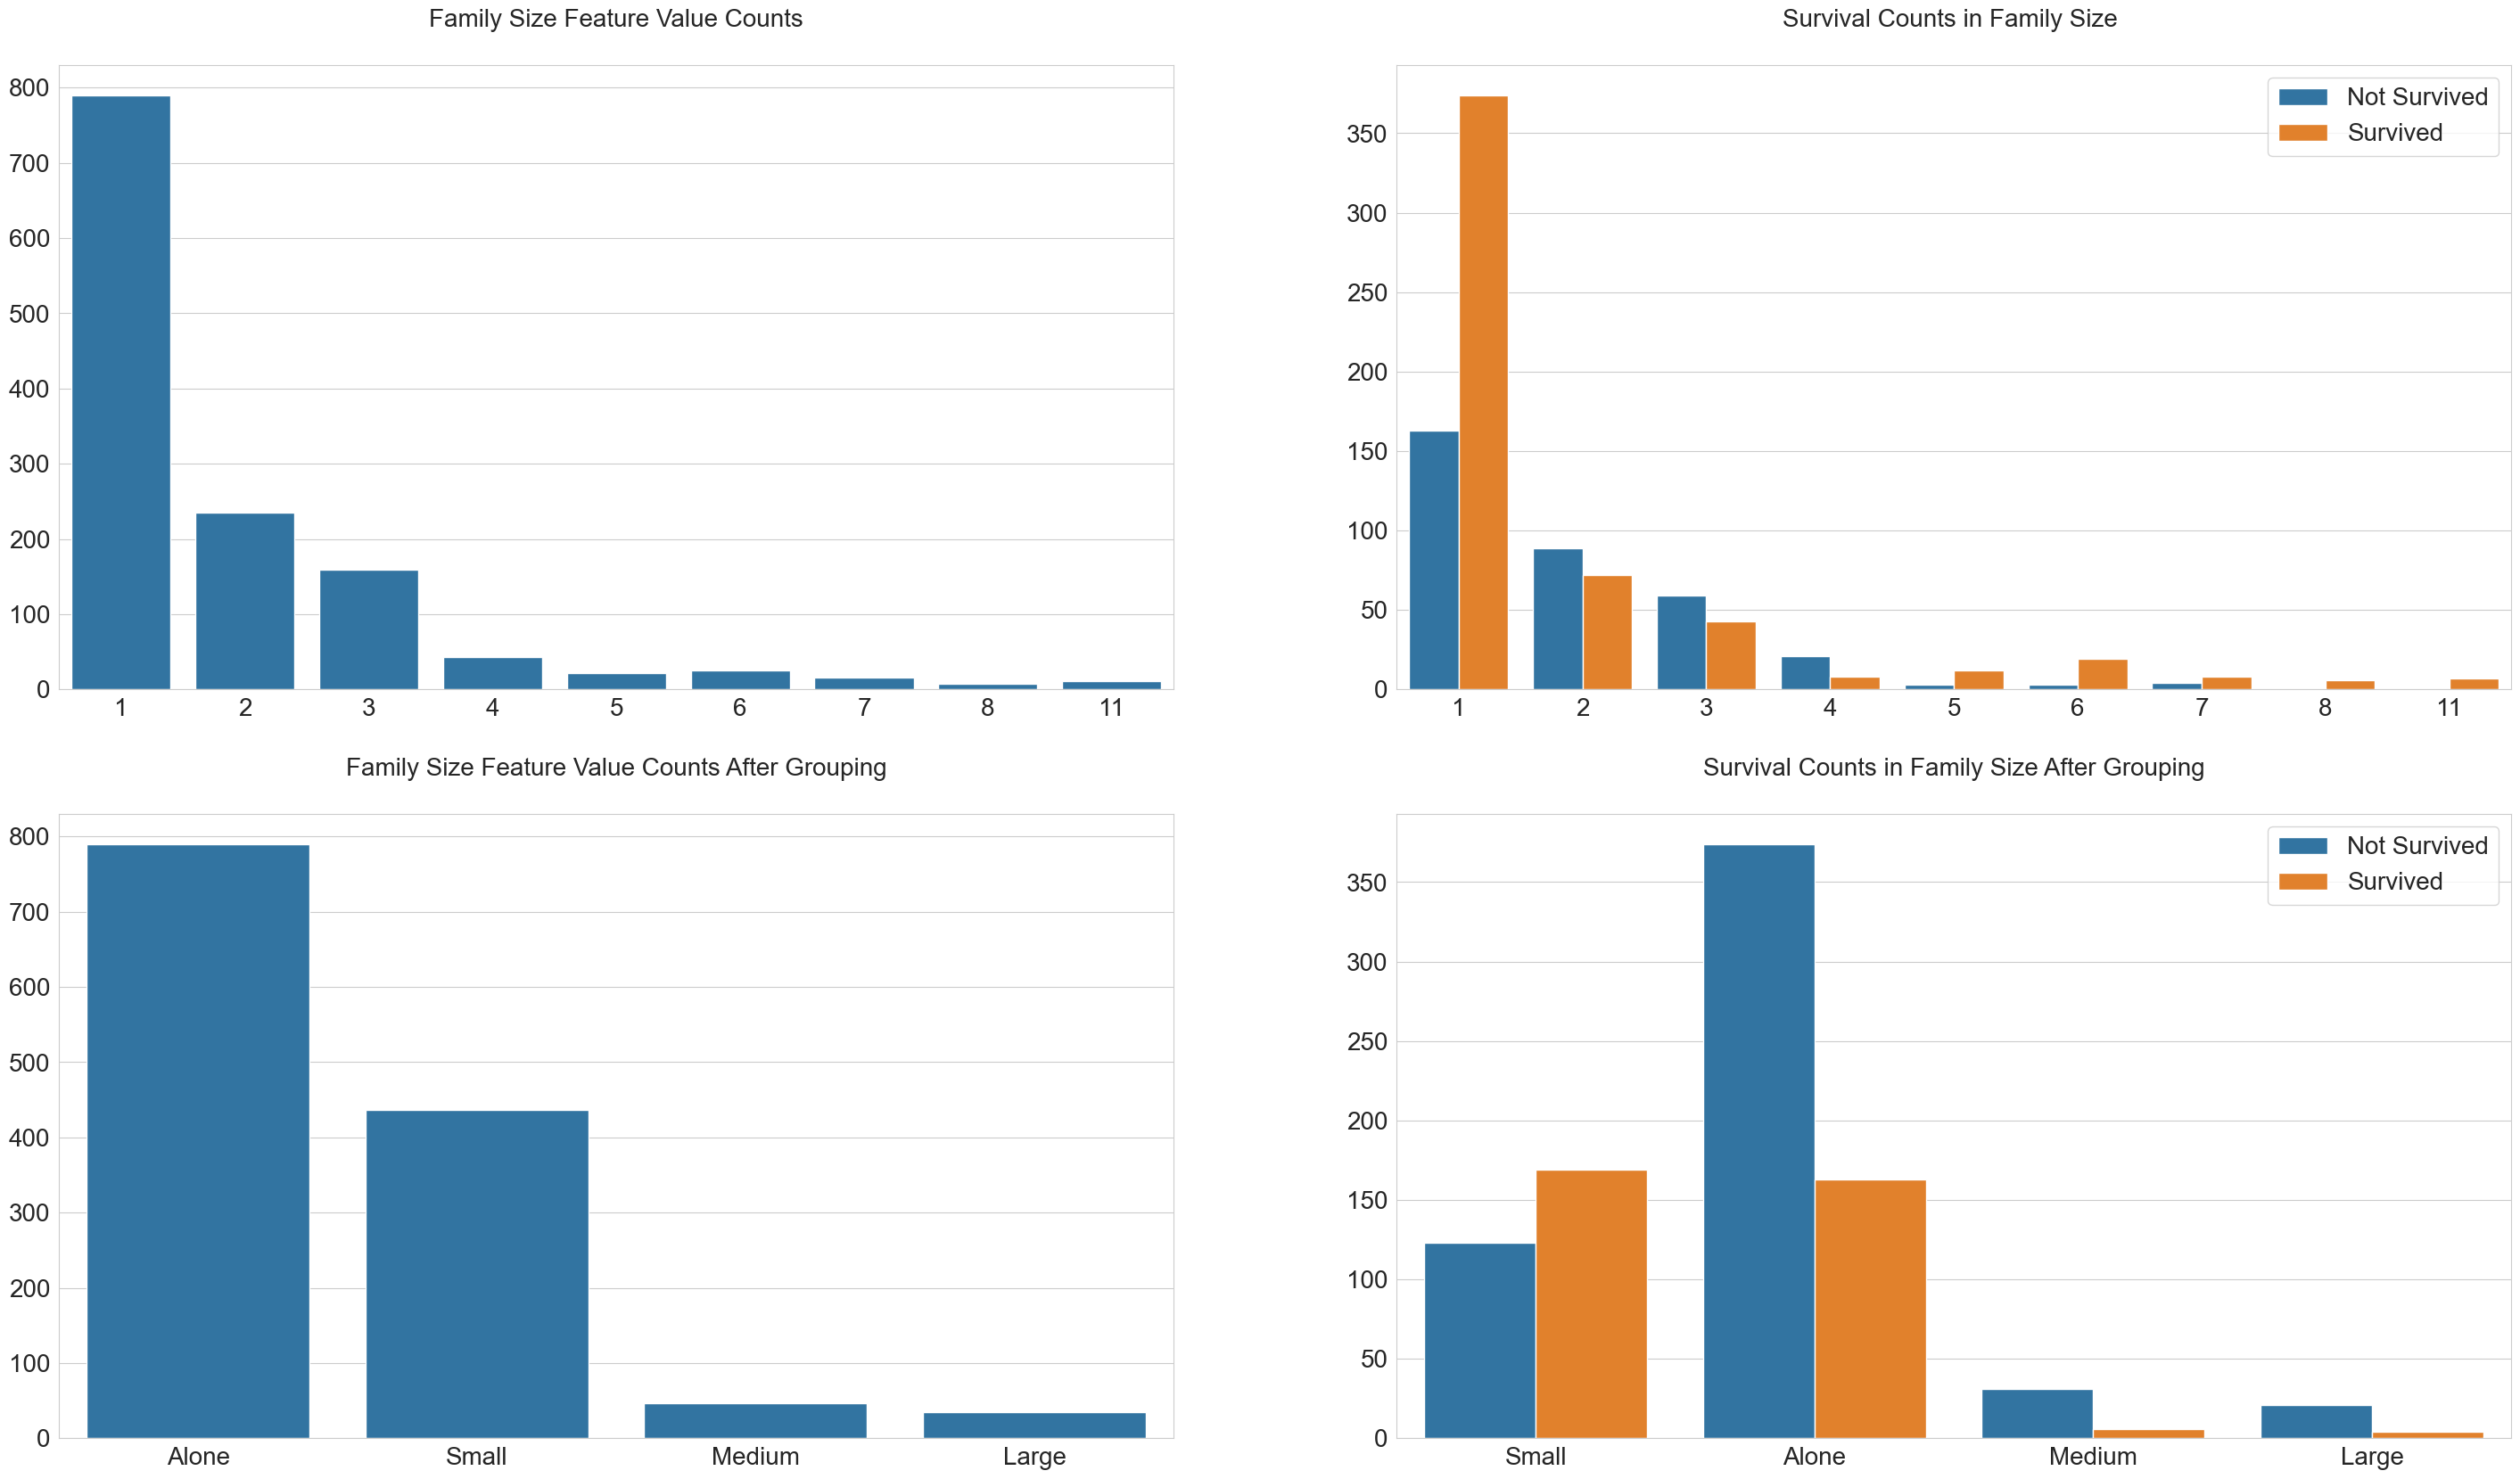

In [75]:
# 1️⃣ Convertir 'SibSp' y 'Parch' a tipo numérico y reemplazar NaN con 0
df_all['SibSp'] = pd.to_numeric(df_all['SibSp'], errors='coerce').fillna(0).astype(int)
df_all['Parch'] = pd.to_numeric(df_all['Parch'], errors='coerce').fillna(0).astype(int)

# 2️⃣ Crear la nueva columna Family_Size
df_all['Family_Size'] = df_all['SibSp'] + df_all['Parch'] + 1

# 3️⃣ Crear la figura y subgráficos
fig, axs = plt.subplots(figsize=(20, 20), ncols=2, nrows=2)
plt.subplots_adjust(right=1.5)

# 4️⃣ Gráfico de distribución de Family_Size
sns.barplot(x=df_all['Family_Size'].value_counts().index, 
            y=df_all['Family_Size'].value_counts().values, ax=axs[0][0])
sns.countplot(x='Family_Size', hue='Survived', data=df_all, ax=axs[0][1])

axs[0][0].set_title('Family Size Feature Value Counts', size=20, y=1.05)
axs[0][1].set_title('Survival Counts in Family Size ', size=20, y=1.05)

# 5️⃣ Agrupar los valores de Family_Size
family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 
              6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}

df_all['Family_Size_Grouped'] = df_all['Family_Size'].map(family_map)

# 6️⃣ Graficar la distribución después de agrupar
sns.barplot(x=df_all['Family_Size_Grouped'].value_counts().index, 
            y=df_all['Family_Size_Grouped'].value_counts().values, ax=axs[1][0])
sns.countplot(x='Family_Size_Grouped', hue='Survived', data=df_all, ax=axs[1][1])

axs[1][0].set_title('Family Size Feature Value Counts After Grouping', size=20, y=1.05)
axs[1][1].set_title('Survival Counts in Family Size After Grouping', size=20, y=1.05)

# 7️⃣ Ajustar las etiquetas y leyendas
for i in range(2):
    axs[i][1].legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 20})
    for j in range(2):
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
        axs[i][j].set_xlabel('')
        axs[i][j].set_ylabel('')

plt.show()


There are too many unique Ticket values to analyze, so grouping them up by their frequencies makes things easier.

How is this feature different than Family_Size? Many passengers travelled along with groups. Those groups consist of friends, nannies, maids and etc. They weren't counted as family, but they used the same ticket.

Why not grouping tickets by their prefixes? If prefixes in Ticket feature has any meaning, then they are already captured in Pclass or Embarked features because that could be the only logical information which can be derived from the Ticket feature.

According to the graph below, groups with 2,3 and 4 members had a higher survival rate. Passengers who travel alone has the lowest survival rate. After 4 group members, survival rate decreases drastically. This pattern is very similar to Family_Size feature but there are minor differences. Ticket_Frequency values are not grouped like Family_Size because that would basically create the same feature with perfect correlation. This kind of feature wouldn't provide any additional information gain.

In [76]:
df_all['Ticket_Frequency'] = df_all.groupby('Ticket')['Ticket'].transform('count')

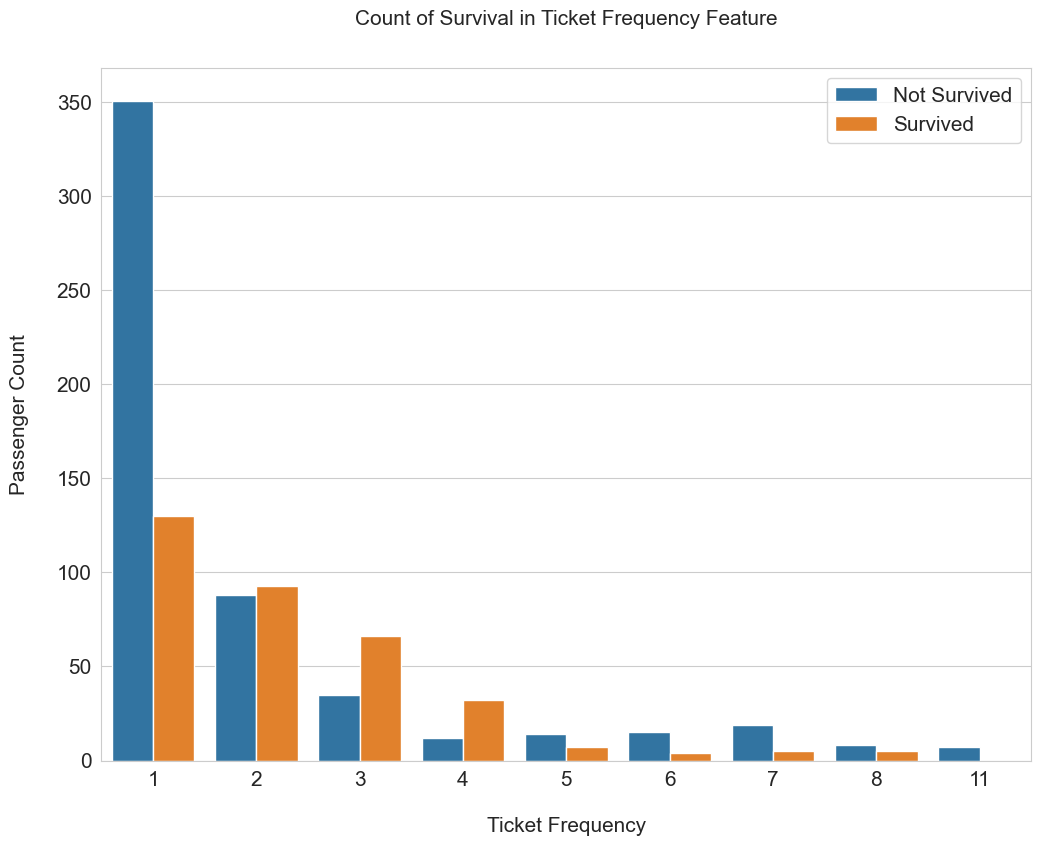

In [77]:
fig, axs = plt.subplots(figsize=(12, 9))
sns.countplot(x='Ticket_Frequency', hue='Survived', data=df_all)

plt.xlabel('Ticket Frequency', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Ticket Frequency'), size=15, y=1.05)

plt.show()

### **2.3 Title & Is Married**
`Title` is created by extracting the prefix before `Name` feature. According to graph below, there are many titles that are occuring very few times. Some of those titles doesn't seem correct and they need to be replaced. **Miss**, **Mrs**, **Ms**, **Mlle**, **Lady**, **Mme**, **the Countess**, **Dona** titles are replaced with **Miss/Mrs/Ms** because all of them are female. Values like **Mlle**, **Mme** and **Dona** are actually the name of the passengers, but they are classified as titles because `Name` feature is split by comma. **Dr**, **Col**, **Major**, **Jonkheer**, **Capt**, **Sir**, **Don** and **Rev** titles are replaced with **Dr/Military/Noble/Clergy** because those passengers have similar characteristics. **Master** is a unique title. It is given to male passengers below age **26**. They have the highest survival rate among all males.

`Is_Married` is a binary feature based on the **Mrs** title. **Mrs** title has the highest survival rate among other female titles. This title needs to be a feature because all female titles are grouped with each other.

In [79]:
df_all['Title'] = df_all['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]

# Crear 'Is_Married' con valores predeterminados en 0
df_all.loc[:, 'Is_Married'] = 0  

# Asignar 1 a quienes tienen el título 'Mrs'
df_all.loc[df_all['Title'] == 'Mrs', 'Is_Married'] = 1  


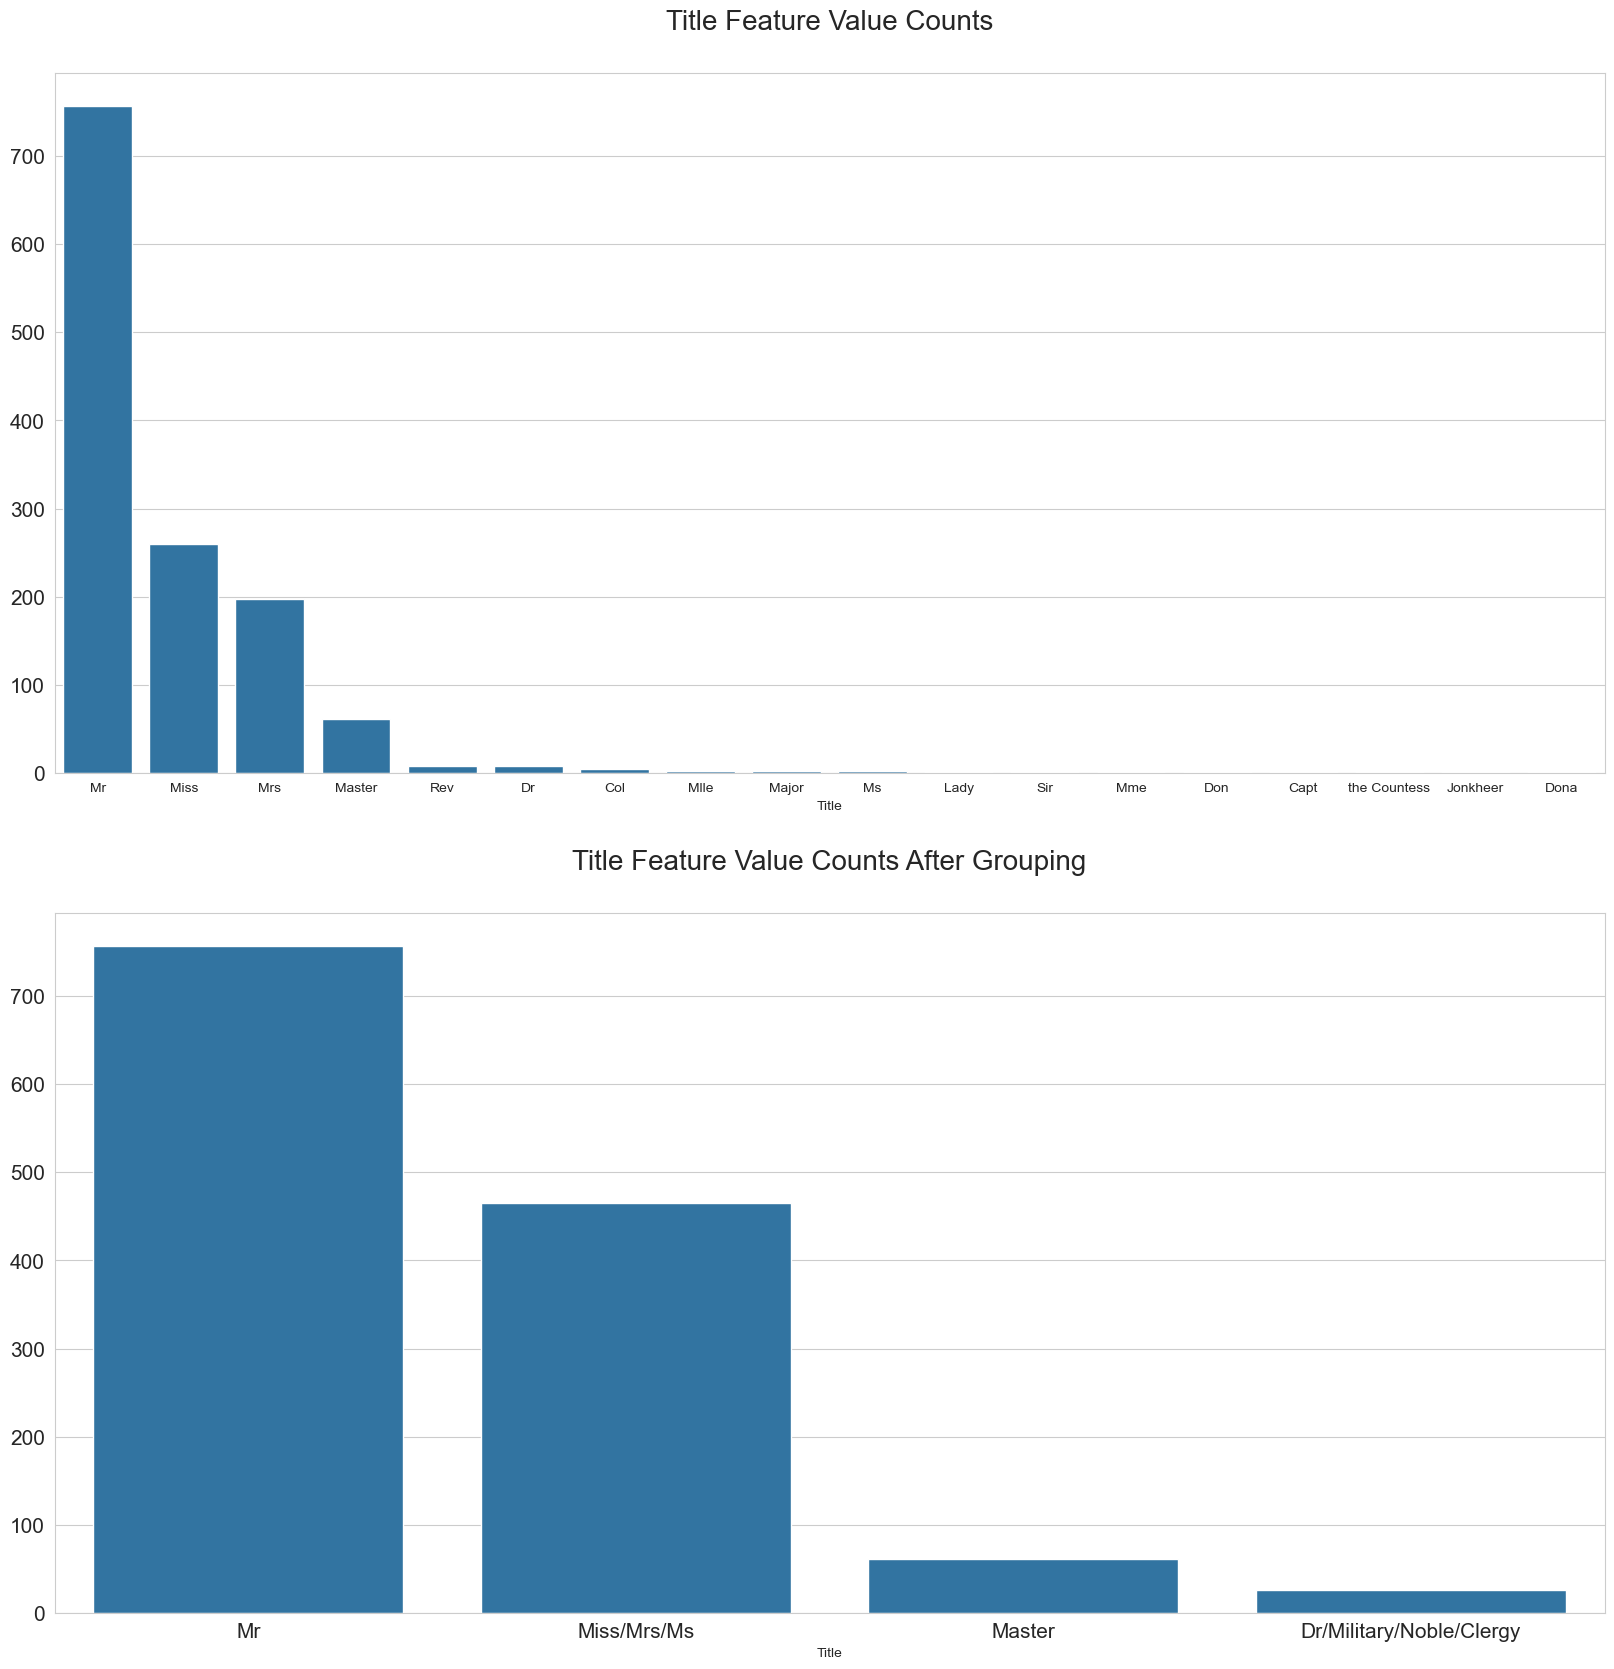

In [80]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))
sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values, ax=axs[0])

axs[0].tick_params(axis='x', labelsize=10)
axs[1].tick_params(axis='x', labelsize=15)

for i in range(2):    
    axs[i].tick_params(axis='y', labelsize=15)

axs[0].set_title('Title Feature Value Counts', size=20, y=1.05)

df_all['Title'] = df_all['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
df_all['Title'] = df_all['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values, ax=axs[1])
axs[1].set_title('Title Feature Value Counts After Grouping', size=20, y=1.05)

plt.show()

We can create another feature called IsAlone.

In [ ]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

We can also create an artificial feature combining Pclass and Age.

In [ ]:
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

train_df.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

### **2.4 Target Encoding**
`extract_surname` function is used for extracting surnames of passengers from the `Name` feature. `Family` feature is created with the extracted surname. This is necessary for grouping passengers in the same family. 

In [82]:
import string  # ✅ Importar la librería string

def extract_surname(data):    
    families = []
    
    for i in range(len(data)):        
        name = data.iloc[i]

        if '(' in name:
            name_no_bracket = name.split('(')[0] 
        else:
            name_no_bracket = name
            
        family = name_no_bracket.split(',')[0]
        title = name_no_bracket.split(',')[1].strip().split(' ')[0]
        
        for c in string.punctuation:  # Ahora `string.punctuation` está definido
            family = family.replace(c, '').strip()
            
        families.append(family)
            
    return families

# Aplicar la función sin errores
df_all['Family'] = extract_surname(df_all['Name'])

# Separar en entrenamiento y prueba
df_train = df_all.loc[:890]
df_test = df_all.loc[891:]
dfs = [df_train, df_test]


`Family_Survival_Rate` is calculated from families in training set since there is no `Survived` feature in test set. A list of family names that are occuring in both training and test set (`non_unique_families`), is created. The survival rate is calculated for families with more than 1 members in that list, and stored in `Family_Survival_Rate` feature.

An extra binary feature `Family_Survival_Rate_NA` is created for families that are unique to the test set. This feature is also necessary because there is no way to calculate those families' survival rate. This feature implies that family survival rate is not applicable to those passengers because there is no way to retrieve their survival rate.

`Ticket_Survival_Rate` and `Ticket_Survival_Rate_NA` features are also created with the same method. `Ticket_Survival_Rate` and `Family_Survival_Rate` are averaged and become `Survival_Rate`, and `Ticket_Survival_Rate_NA` and `Family_Survival_Rate_NA` are also averaged and become `Survival_Rate_NA`.

In [84]:



# Crear una lista de familias y tickets que aparecen en ambos conjuntos de datos
non_unique_families = [x for x in df_train['Family'].unique() if x in df_test['Family'].unique()]
non_unique_tickets = [x for x in df_train['Ticket'].unique() if x in df_test['Ticket'].unique()]

# ✅ Convertir las columnas a tipo numérico (si hay errores, poner NaN)
# Convertir las columnas a tipo numérico de forma segura
df_train.loc[:, 'Survived'] = pd.to_numeric(df_train['Survived'], errors='coerce')
df_train.loc[:, 'Family_Size'] = pd.to_numeric(df_train['Family_Size'], errors='coerce')
df_train.loc[:, 'Ticket_Frequency'] = pd.to_numeric(df_train['Ticket_Frequency'], errors='coerce')

# ✅ Calcular la mediana ahora que los valores son numéricos
df_family_survival_rate = df_train.groupby('Family')[['Survived', 'Family_Size']].median()
df_ticket_survival_rate = df_train.groupby('Ticket')[['Survived', 'Ticket_Frequency']].median()

# Diccionarios para almacenar tasas de supervivencia
family_rates = {}
ticket_rates = {}

# ✅ Verificar la existencia de la familia en ambos conjuntos y si tiene más de un miembro
for i in range(len(df_family_survival_rate)):
    if df_family_survival_rate.index[i] in non_unique_families and df_family_survival_rate.iloc[i, 1] > 1:
        family_rates[df_family_survival_rate.index[i]] = df_family_survival_rate.iloc[i, 0]

# ✅ Verificar la existencia del ticket en ambos conjuntos y si tiene más de un miembro
for i in range(len(df_ticket_survival_rate)):
    if df_ticket_survival_rate.index[i] in non_unique_tickets and df_ticket_survival_rate.iloc[i, 1] > 1:
        ticket_rates[df_ticket_survival_rate.index[i]] = df_ticket_survival_rate.iloc[i, 0]

In [86]:
mean_survival_rate = np.mean(df_train['Survived'])

train_family_survival_rate = []
train_family_survival_rate_NA = []
test_family_survival_rate = []
test_family_survival_rate_NA = []

for i in range(len(df_train)):
    if df_train['Family'][i] in family_rates:
        train_family_survival_rate.append(family_rates[df_train['Family'][i]])
        train_family_survival_rate_NA.append(1)
    else:
        train_family_survival_rate.append(mean_survival_rate)
        train_family_survival_rate_NA.append(0)
        
for i in range(len(df_test)):
    if df_test['Family'].iloc[i] in family_rates:
        test_family_survival_rate.append(family_rates[df_test['Family'].iloc[i]])
        test_family_survival_rate_NA.append(1)
    else:
        test_family_survival_rate.append(mean_survival_rate)
        test_family_survival_rate_NA.append(0)
        
df_train.loc[:, 'Family_Survival_Rate'] = train_family_survival_rate
df_train.loc[:, 'Family_Survival_Rate_NA'] = train_family_survival_rate_NA
df_test.loc[:, 'Family_Survival_Rate'] = test_family_survival_rate
df_test.loc[:, 'Family_Survival_Rate_NA'] = test_family_survival_rate_NA

train_ticket_survival_rate = []
train_ticket_survival_rate_NA = []
test_ticket_survival_rate = []
test_ticket_survival_rate_NA = []

for i in range(len(df_train)):
    if df_train['Ticket'][i] in ticket_rates:
        train_ticket_survival_rate.append(ticket_rates[df_train['Ticket'][i]])
        train_ticket_survival_rate_NA.append(1)
    else:
        train_ticket_survival_rate.append(mean_survival_rate)
        train_ticket_survival_rate_NA.append(0)
        
for i in range(len(df_test)):
    if df_test['Ticket'].iloc[i] in ticket_rates:
        test_ticket_survival_rate.append(ticket_rates[df_test['Ticket'].iloc[i]])
        test_ticket_survival_rate_NA.append(1)
    else:
        test_ticket_survival_rate.append(mean_survival_rate)
        test_ticket_survival_rate_NA.append(0)
        
df_train.loc[:, 'Ticket_Survival_Rate'] = train_ticket_survival_rate
df_train.loc[:, 'Ticket_Survival_Rate_NA'] = train_ticket_survival_rate_NA
df_test.loc[:, 'Ticket_Survival_Rate'] = test_ticket_survival_rate
df_test.loc[:, 'Ticket_Survival_Rate_NA'] = test_ticket_survival_rate_NA

In [89]:
for df in [df_train, df_test]:
    df.loc[:, 'Survival_Rate'] = (df['Ticket_Survival_Rate'] + df['Family_Survival_Rate']) / 2
    df.loc[:, 'Survival_Rate_NA'] = (df['Ticket_Survival_Rate_NA'] + df['Family_Survival_Rate_NA']) / 2


### **2.5 Feature Transformation**


#### **2.5.1 Label Encoding Non-Numerical Features**
`Embarked`, `Sex`, `Deck` , `Title` and `Family_Size_Grouped` are object type, and `Age` and `Fare` features are category type. They are converted to numerical type with `LabelEncoder`. `LabelEncoder` basically labels the classes from **0** to **n**. This process is necessary for models to learn from those features.

In [93]:
from sklearn.preprocessing import LabelEncoder

non_numeric_features = ['Embarked', 'Sex', 'Deck', 'Title', 'Family_Size_Grouped', 'Age', 'Fare']

for df in dfs:
    for feature in non_numeric_features:        
        df.loc[:, feature] = LabelEncoder().fit_transform(df[feature])



#### **2.5.2 One-Hot Encoding the Categorical Features**
The categorical features (`Pclass`, `Sex`, `Deck`, `Embarked`, `Title`) are converted to one-hot encoded features with `OneHotEncoder`. `Age` and `Fare` features are not converted because they are ordinal unlike the previous ones.

In [96]:
from sklearn.preprocessing import OneHotEncoder
cat_features = ['Pclass', 'Sex', 'Deck', 'Embarked', 'Title', 'Family_Size_Grouped']
encoded_features = []

for df in dfs:
    for feature in cat_features:
        encoded_feat = OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
        n = df[feature].nunique()
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)

df_train = pd.concat([df_train, *encoded_features[:6]], axis=1)
df_test = pd.concat([df_test, *encoded_features[6:]], axis=1)

### **2.6 Conclusion**
`Age` and `Fare` features are binned. Binning helped dealing with outliers and it revealed some homogeneous groups in those features. `Family_Size` is created by adding `Parch` and `SibSp` features and **1**. `Ticket_Frequency` is created by counting the occurence of `Ticket` values.

`Name` feature is very useful. First, `Title` and `Is_Married` features are created from the title prefix in the names. Second, `Family_Survival_Rate` and `Family_Survival_Rate_NA`  features are created by target encoding the surname of the passengers. `Ticket_Survival_Rate` is created by target encoding the `Ticket` feature. `Survival_Rate` feature is created by averaging the `Family_Survival_Rate` and `Ticket_Survival_Rate` features.

Finally, the non-numeric type features are label encoded and categorical features are one-hot encoded. Created **5** new features (`Family_Size`, `Title`, `Is_Married`, `Survival_Rate` and `Survival_Rate_NA`) and dropped the useless features after encoding.

In [98]:
import pandas as pd

def concat_df(train_data, test_data):
    # Eliminar columnas completamente vacías antes de la concatenación
    train_data = train_data.dropna(axis=1, how='all')
    test_data = test_data.dropna(axis=1, how='all')
    
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

# Aplicar la función corregida
df_all = concat_df(df_train, df_test)

drop_cols = ['Deck', 'Embarked', 'Family', 'Family_Size', 'Family_Size_Grouped', 'Survived',
             'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Ticket', 'Title',
             'Ticket_Survival_Rate', 'Family_Survival_Rate', 'Ticket_Survival_Rate_NA', 'Family_Survival_Rate_NA']

# Eliminar solo las columnas que realmente existen en df_all (para evitar errores)
df_all = df_all.drop(columns=[col for col in drop_cols if col in df_all.columns], errors='ignore')

df_all.head()


,Age,Deck_1,Deck_2,Deck_3,Deck_4,Embarked_1,Embarked_2,Embarked_3,Family_Size_Grouped_1,Family_Size_Grouped_2,...,Pclass_3,Sex_1,Sex_2,Survival_Rate,Survival_Rate_NA,Ticket_Frequency,Title_1,Title_2,Title_3,Title_4
0,28,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.383838,0.0,1,0.0,0.0,0.0,1.0
1,52,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.000000,1.0,2,0.0,0.0,1.0,0.0
2,34,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.383838,0.0,1,0.0,0.0,1.0,0.0
3,48,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.383838,0.0,2,0.0,0.0,1.0,0.0
4,48,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.383838,0.0,1,0.0,0.0,0.0,1.0


### Model, predict
Ahora estamos listos para entrenar un modelo y predecir la solución requerida. Hay más de 60 algoritmos de modelado predictivo para elegir. Debemos comprender el tipo de problema y el requisito de solución para limitarnos a unos pocos modelos seleccionados que podamos evaluar. Nuestro problema es un problema de clasificación y regresión. Queremos identificar la relación entre el resultado (sobrevivido o no) con otras variables o características (género, edad, puerto...). También estamos realizando una categoría de aprendizaje automático que se llama aprendizaje supervisado, ya que estamos entrenando nuestro modelo con un conjunto de datos determinado. Con estos dos criterios (aprendizaje supervisado más clasificación y regresión), podemos limitar nuestra elección de modelos a unos pocos. Estos incluyen:  
Logistic Regression
KNN or k-Nearest Neighbors
Support Vector Machines
Naive Bayes classifier
Decision Tree
Random Forrest
Perceptron
Artificial neural network
RVM or Relevance Vector Machine

#### Logistic Regression  
La regresión logística es un modelo útil para ejecutar en las primeras fases del flujo de trabajo. La regresión logística mide la relación entre la variable dependiente categórica (característica) y una o más variables independientes (características) estimando probabilidades mediante una función logística, que es la distribución logística acumulativa. Referencia Wikipedia.

Observe el puntaje de confianza generado por el modelo en función de nuestro conjunto de datos de entrenamiento.

In [ ]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

Podemos utilizar la regresión logística para validar nuestras suposiciones y decisiones para crear y completar objetivos de características. Esto se puede hacer calculando el coeficiente de las características en la función de decisión.

Los coeficientes positivos aumentan las probabilidades logarítmicas de la respuesta (y, por lo tanto, aumentan la probabilidad), y los coeficientes negativos disminuyen las probabilidades logarítmicas de la respuesta (y, por lo tanto, disminuyen la probabilidad).

El sexo es el coeficiente positivo más alto, lo que implica que a medida que aumenta el valor del sexo (hombre: 0 a mujer: 1), la probabilidad de que haya sobrevivido = 1 aumenta más.
Inversamente, a medida que aumenta la Pclass, la probabilidad de que haya sobrevivido = 1 disminuye más.
De esta manera, la edad*clase es una buena característica artificial para modelar, ya que tiene la segunda correlación negativa más alta con la de que haya sobrevivido.
También lo es el título, que tiene la segunda correlación positiva más alta.

In [ ]:
coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

#### SVM
A continuación, modelamos utilizando máquinas de vectores de soporte, que son modelos de aprendizaje supervisado con algoritmos de aprendizaje asociados que analizan los datos utilizados para la clasificación y el análisis de regresión. Dado un conjunto de muestras de entrenamiento, cada una marcada como perteneciente a una u otra de dos categorías, un algoritmo de entrenamiento de SVM crea un modelo que asigna nuevas muestras de prueba a una u otra categoría, lo que lo convierte en un clasificador lineal binario no probabilístico. Referencia Wikipedia.

Tenga en cuenta que el modelo genera un puntaje de confianza que es más alto que el modelo de regresión logística.

In [ ]:
# Support Vector Machines

svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc